In [1]:
'''
Available methods are the followings:
[1] TreeExplainer
[2] MultiInterval

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 15-01-2022

'''
import numpy as np, pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.ticker import(FixedLocator, 
                              FixedFormatter, 
                              StrMethodFormatter,
                              FuncFormatter)
from matplotlib.patches import Patch, FancyArrowPatch
from matplotlib.lines import Line2D

import sklearn
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier, 
                              RandomForestRegressor, 
                              ExtraTreesRegressor)
from sklearn.tree import (DecisionTreeRegressor, 
                          DecisionTreeClassifier, 
                          _tree)

from distutils.version import LooseVersion
from sklearn.linear_model import HuberRegressor 
from sklearn.neighbors import KernelDensity
from scipy.stats import (spearmanr, pearsonr, 
                         chi2, gaussian_kde)

# Adding fonts
from matplotlib import font_manager
paths = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
for font_path in paths:
    if font_path.find("Hiragino Sans GB W3")>-1: 
        try:
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = prop.get_name()
            plt.rcParams.update({'font.family':'sans-serif'})
            plt.rcParams.update({'font.sans-serif':prop.get_name()})
            plt.rc('axes', unicode_minus=False)
            break
        except:pass

__all__ = ["TreeExplainer", "MultiInterval"]

if LooseVersion(sklearn.__version__) < LooseVersion("0.17"):
    raise Exception("TreeExplainer requires scikit-learn 0.17 or later")

In [2]:
def MultiInterval(y, x, criterion="iv", equal_width=True, bins="fd", 
                  min_pct=0.05, min_cls=0.05, trend="auto"):

    '''
    ** Multi-Interval Discretization ** (modified)
    
    [1] For each interval, divide input into several cut points. 
    [2] For each cut point, compute the criterion that satisfies trend 
        of WOEs and optimizes objective function. If None, no cutoff is 
        selected for this bin.
    [3] Repeat [1] and [2] until no cutoff is made or number of bins 
        equals to 2.

    Parameters
    ----------
    y : array of int, of shape (n_samples,)
        Array of classes or labels.

    x : array of float, of shape (n_samples,)
        Array of values to be binned.

    criterion : {"iv", "gini", "entropy"}, default="iv"
        The function to measure the quality of a split. Supported 
        criteria are "iv" for the information value, "gini" for the Gini 
        impurity and "entropy" for the information gain. 
        
    equal_width : bool, default=True
        If True, it uses equal-width binning, otherwise equal-sample 
        binning is used instead. 
        
    bins : int or str, default="fd"
        - If int, it defines the number of bins. bins must be integer
          when `equal_width` is False (equal-sample). 
        - If str, it defines the method used to calculate the optimal 
          bin width, as defined by `numpy.histogram_bin_edges`. This is 
          relevant when `equal_width` is True.
          
    min_pct : float, default=0.05
        Minimum percentage of samples (event and non-event) in each bin.
 
    min_cls : float, default=0.05
        Minimum positive percentage of event and non-event samples wrt. 
        their totals in each bin.
        
    trend : {"auto", "downward", "upward"}, default="auto"
        The followings are the values that must be specified;
        - "downward" : Downward trend of WOEs.
        - "upward"   : Upward trend of WOEs. 
        - "auto"     : Allow function to determine trend automatically.

    Returns
    -------
    Results : collections.namedtuple
        - "woe"      : Weight of Evidence
        - "iv"       : Information Value
        - "target"   : Target rate
        - "bin_edges": Bin edges
    
    '''
    r_min = np.nanmin(x)
    r_max = np.nanmax(x) * 1.01
    
    # Keyword arguments for `OptimalCutoff`
    kwds = {"r_min"   : r_min, 
            "r_max"   : r_max,
            "bins"    : bins,
            "min_pct" : min_pct,
            "min_cls" : min_cls,
            "trend"   : trend,
            "criterion"   : criterion, 
            "equal_width" : equal_width}

    result = OptimalCutoff(y, x, **kwds)
    if result.cutoff is not None: 
        
        # Initial bin_edges.
        bin_edges = [r_min, result.cutoff, r_max]
        kwds.update({"trend" : result.trend})
    
        while True:
            n_bins, new_bin_edges = len(bin_edges), []
            for n in range(n_bins-1):
                kwds.update(dict(r_min = bin_edges[n], 
                                 r_max = bin_edges[n+1]))
                r = OptimalCutoff(y, x, **kwds)
                if r.cutoff is not None: new_bin_edges += [r.cutoff]
            
            # Update bin edges
            bin_edges += new_bin_edges
            bin_edges  = np.unique(bin_edges).tolist() 
            if (len(bin_edges)==n_bins) | (len(bin_edges)<4): break
                
    else:
        mid_point = np.nanmedian(x)
        if (mid_point!=r_min) & (mid_point!=r_max):
            bin_edges = [r_min, mid_point, r_max]
        else: bin_edges = [r_min, np.nanmean(x), r_max]
    
    return monotonic_woe(y, x, bin_edges)

In [3]:
def monotonic_woe(y, x, bins):
        
    '''
    In case that WOEs don't form a monotonic trend either upward or 
    downward (majority vote), `monotonic_woe` will collaspe bins (to 
    the left) that does not follow trend one at a time, until either 
    all WOEs are in the same direction or number of bins equals to 2, 
    whatever comes first. 

    Parameters
    ----------
    y : array of int
        Array of classes or labels.

    x : array of float
        Array of values to be binned.

    bins : sequence of scalars
        Sequence of scalars must be a monotonically increasing array 
        of bin edges, including the rightmost edge.
   
    Returns
    -------
    Results : collections.namedtuple
        - "woe"      : Weight of Evidence
        - "iv"       : Information Value
        - "target"   : Target rate
        - "bin_edges": Bin edges
    
    '''
    y0 = y[~np.isnan(x)].copy()
    x0 = x[~np.isnan(x)].copy()
    bin_edges = np.array(bins).copy()

    while True:

        dist, n_bins = [], len(bin_edges)
        for label in range(2):
            a = np.histogram(x[y==label], bin_edges)[0]
            dist += [np.where(a==0, 0.5, a) / sum(a)]
        
        # ===================================================
        # There is an adjacent bin, whose `WOE` equals. The 
        # current bin will be collasped to the left.
        woe = np.log(dist[0]/dist[1])
        direction = np.sign(np.diff(woe))
        if (direction==0).sum()>0: 
            index = np.full(len(direction),True)
            index[np.argmax((direction==0))] = False
        else:   
            index = np.where(direction<0, 0, 1) 
            index = (index==np.argmax(np.bincount(index)))
        index = np.hstack(([True], index, [True]))
        # ---------------------------------------------------
        # Keep bin edges that follow the trend.
        if len(bin_edges)>3: bin_edges = bin_edges[index]
        if (len(bin_edges)==n_bins)|(len(bin_edges)<4):break
        # ===================================================
  
    keys = ['woe', 'iv', 'target', 'bin_edges']
    Results = collections.namedtuple('Results', keys)
    return Results(*(woe, (dist[0] - dist[1]) * woe, 
                     dist[1]/(dist[0] + dist[1]), bin_edges))

In [4]:
def OptimalCutoff(y, x, r_min=None, r_max=None, criterion="iv", 
                  equal_width=True, bins="fd", min_pct=0.05, 
                  min_cls=0.05, trend="auto"):

    '''
    Find the optimum cut point that satisfies the objective function. 

    Parameters
    ----------
    y : array of int
        Array of classes or labels.

    x : array of float
        Array of values to be binned.

    r_min : float, default=None
        Minimum value of `x` (r_min ≤ x). If None, it defaults to 
        minimum of `x`.

    r_max : float, default=None
        Maximum value of `x` (x < r_max). If None, if defaults to 
        maximum of `x` plus the next smallest representable float larger 
        than 1.0.
        
    criterion : {"iv", "gini", "entropy"}, default="iv"
        The function to measure the quality of a split. Supported 
        criteria are "iv" for the information value, "gini" for the Gini 
        impurity and "entropy" for the information gain.
        
    equal_width : bool, default=True
        If True, it uses equal-width binning, otherwise equal-sample 
        binning is used instead. 
        
    bins : int or str, default="fd"
        - If int, it defines the number of bins. bins must be integer
          when `equal_width` is False (equal-sample). 
        - If str, it defines the method used to calculate the optimal 
          bin width, as defined by `numpy.histogram_bin_edges`. This is 
          relevant when `equal_width` is True.
          
    min_pct : float, default=0.05
        Minimum percentage of samples (event and non-event) in each bin.
 
    min_cls : float, default=0.05
        Minimum positive percentage of event and non-event samples wrt. 
        their totals in each bin.
        
    trend : {"auto", "downward", "upward"}, default="auto"
        The followings are the values that must be specified;
        - "downward" : Downward trend of WOEs.
        - "upward"   : Upward trend of WOEs. 
        - "auto"     : Allow function to determine trend automatically.

    Returns
    -------
    Results : collections.namedtuple
        - "left_woe" : WOE from the left side of the split
        - "right_woe": WOE from the right side of the split
        - "cutoff"   : Best cutoff
        - "gain"     : Information gain
        - "trend"    : Trend of WOEs i.e. {"upward", "downward"}
    
    '''
    # Functions
    WOEs = lambda a0, a1 : np.log(a0/a1) if a1>0 else 0
    IVs  = lambda a0, a1 : (a0 - a1) * WOEs(a0, a1)
    if r_min is None: r_min = np.nanmin(x)
    if r_max is None: r_max = np.nanmax(x)
        
    if criterion not in ['iv','gini','entropy']:
        raise ValueError(f"OptimalCutoff can be used when method is 'iv'," 
                         f"'gini', and 'entropy'. Got (method={method})")

    # Find total number of samples for classes.
    n_samples = np.bincount(y) 

    # Accept values that are not null and stay within 
    # defined boundary.
    cond = ((~np.isnan(x)) & (r_min<=x) & (x<r_max))
    x0 = x[cond].astype(float).copy()
    y0 = y[cond].astype(int).copy()

    # Determine cutoffs.
    cutoffs = sub_intervals(x0, bins, equal_width)
    left_woe, right_woe, new_cutoff, gain = [],[],[],[]
    
    # Precompute beginning value.
    if criterion == 'entropy': Begin = Entropy(y0, x0)
    elif criterion == 'gini' : Begin = GiniImpurity(y0, x0)
 
    if len(cutoffs)-2 > 0:

        for cutoff in cutoffs[1:-1]:

            left_dist  = [sum((y0[x0< cutoff]==n)/n_samples[n]) for n in [0,1]]
            right_dist = [sum((y0[x0>=cutoff]==n)/n_samples[n]) for n in [0,1]]

            # =======================================================
            # In order for WOE to be valid, 2 following conditions 
            # must be satisfied;
            # [1] Bin should contain at least 5% observations or be 
            # ... greater than or equal to defined minimum.
            # [2] Bin must not have 0 accounts for all classes or be 
            # ... greater than or equal to defined minimum.
            # -------------------------------------------------------
            cond1 = (min_pct <= min(sum(x0<cutoff), 
                                    sum(x0>=cutoff))/len(y))
            cond2 = (min_cls <= min(left_dist[0], right_dist[0]))
            cond3 = (min_cls <= min(left_dist[1], right_dist[1]))
            # =======================================================

            if (cond1 & cond2 & cond3):

                left_woe   += [WOEs(*left_dist)]
                right_woe  += [WOEs(*right_dist)]
                new_cutoff += [cutoff]

                # ================================================
                if criterion == 'iv': 
                    gain += [IVs(*left_dist) + IVs(*right_dist)]
                elif criterion == 'entropy':
                    gain += [Begin - Entropy(y0, x0, cutoff)]
                elif criterion == 'gini':
                    gain += [Begin - GiniImpurity(y0, x0, cutoff)]
                else: pass
                # ================================================
                
    else: pass
      
    if len(gain)>0:

        # Convert parameters to np.ndarray
        left_woe  = np.array(left_woe)
        right_woe = np.array(right_woe) 
        direction = np.where(left_woe <= right_woe, 1, 0)
        cutoff    = np.array(new_cutoff)
        gain      = np.array(gain)

        # =======================================================
        # If trend is not defined i.e. "downward" or "upward", it
        # will determine by counting `trend` and take direction 
        # that has a majority of counts.
        # -------------------------------------------------------
        if trend=='auto': 
            corr  = sum(direction==1)/len(direction)
            trend = "downward" if corr<0.5 else "upward"
        else: corr = 0. if trend=="downward" else 1.
        index = direction==(0. if (corr < 0.5) else 1.)
        # -------------------------------------------------------
        if sum(index)>0: # solution must exist
            if max(gain)>0: # gain must be greater than 0.
                best_index = index & (gain==max(gain[index]))
            else: best_index = None
        else: best_index = None
        # =======================================================
        
    else: best_index = None
    
    keys = ['left_woe', 'right_woe', 'cutoff', 'gain', 'trend']
    Results = collections.namedtuple('Results', keys)
    if best_index is None: return Results(*((None,)*5))
    else: return Results(*(float(left_woe[best_index]), 
                           float(right_woe[best_index]), 
                           float(cutoff[best_index]), 
                           float(gain[best_index]), trend))

In [5]:
def sub_intervals(x, bins="fd", equal_width=True):

    '''
    Parameters
    ----------
    x : array of float
        Array of values to be binned.
    
    equal_width : bool, default=True
        If True, it uses equal-width binning, otherwise equal-sample 
        binning is used instead. 
        
    bins : int or str, default="fd"
        - If int, it defines the number of bins. 
        - If str, it defines the method used to calculate the optimal 
          bin width, as defined by `numpy.histogram_bin_edges`. This 
          is relevant when `equal_width` is True.
        
    Returns
    -------
    bin_edges : array
    
    '''
    if equal_width: # Equal width
        if isinstance(bins, int):
            a_min, a_max = np.nanpercentile(x, [0,100])
            return np.linspace(a_min, a_max, bins+1)
        else: return np.histogram_bin_edges(x, bins=bins) 
    else: # Equal sample
        if isinstance(bins, int):
            q = np.linspace(0, 100, bins+1)
            return np.unique(np.percentile(x, q))
        else: raise ValueError(f"When `equal_width` is False, bin must be" 
                               f"positive integer. Got {bins} instead.")

In [6]:
def Entropy(y, x, cutoff=None):

    '''
    Multi-interval Discretization (entropy).
    
    $Entropy = - \sum_{i=1}^{c}(P_{i})\log_{2}(P_{i})$

    Parameters
    ----------
    y : array of int
        Array of classes or labels.

    x : array of float
        Array of values to be binned.

    cutoff : float, default=None
        Cutoff to split x into 2 portions i.e. left-side (x < cutoff), 
        and right-side (x >= cutoff). If None, it defaults to `np.max`.

    Returns
    -------
    entropy : float
    
    '''
    # Exclude all missings.
    x0 = x[~np.isnan(x)].astype(float).copy()
    y0 = y[~np.isnan(x)].astype(int).copy()
    if cutoff==None: cutoff=max(x0)

    entropy = 0
    for cond in [(x0<cutoff), (x0>=cutoff)]:
        P = np.bincount(y0[cond])/sum(cond)
        value = -sum(P[P>0] * np.log2(P[P>0])) if len(P)>0 else 0 
        entropy += (sum(cond)/len(y0)) * value

    return entropy

In [7]:
def GiniImpurity(y, x, cutoff=None):

    '''
    Multi-interval Discretization (Gini-impurity).
    
    $Gini = 1 - \sum_{i=1}^{c}(P_{i})^{2}$

    Parameters
    ----------
    y : array of int
        Array of classes or labels.

    x : array of float
        Array of values to be binned.

    cutoff : float, default=None
        Cutoff to split x into 2 portions i.e. left-side (x < cutoff), 
        and right-side (x >= cutoff). If None, it defaults to `np.max`.

    Returns
    -------
    gini : float
    
    '''
    # Exclude all missings.
    x0 = x[~np.isnan(x)].astype(float).copy()
    y0 = y[~np.isnan(x)].astype(int).copy()
    if cutoff==None: cutoff=max(x0)
        
    gini = 0
    for cond in [(x0<cutoff), (x0>=cutoff)]:
        value  = 1 - sum(pow(np.bincount(y0[cond])/sum(cond),2))
        gini  += (len(y0[cond])/len(y0)) * value
    return gini

In [8]:
def waterfall_base(biases, contributions, X, y, index=0, sort_by=None, 
                   max_display=10, colors=None, tight_layout=True, 
                   ax=None, char_length=20, anno_format=None, 
                   text_format=None, classifier=True):
    
    '''
    Waterfall plot of directional feature contributions.
    
    Parameters
    ----------
    biases : np.ndarray, of shape (n_samples, 2)
        Initial bias for each class. Bias is the target proportion of
        training set (after bootstrapping) of every single tree. This
        is the ouput from `treeinterpreter` [1].
    
    contributions : np.ndarray, of shape (n_samples, n_features)
        The average contribution of features. This is the ouput from 
        `treeinterpreter` [1].
    
    X : pd.DataFrame of shape (n_samples, n_features) 
        The input samples. 

    y : array-like of shape (n_samples,)
        The class labels (binary).
    
    index : int, default=0
        Index of record from `X`. If None, it defautls to average 
        value of contributions.
     
    sort_by : {"contribution", "value", None}, default=None
        The function to sort feature contributions. Supported 
        criteria are "contribution" for absolute value sorting, and 
        "value" for normal value sorting. If None, no sorting is 
        implemented.
        
    max_display : int, default=10
        Maximum number of variables to be displayed. This is relevant
        when `sort_by` is "contribution".
       
    colors : list of color-hex, default=None
        Color-hex must be arranged in the follwoing order i.e.
        ["Negative Contribution", "Positive Contribution"]. If None, 
        it uses default colors from Matplotlib.
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis.
        
    char_length : int, greater than 1, default=20
        Length of feature characters to be displayed.

    anno_format : string formatter, default=None
        String formatters for ax.annotate. If None, it defaults to 
        "{:+,.5g}".format for regression or "{:+,.2%}".format for 
        classification. 
        
    text_format : string formatter, default=None
        String formatters for ax.text. If None, it defaults to 
        "{:,.5g}".format for regression or "{:,.2%}".format for 
        classification.
        
    classifier : bool, default=True
        If True, it assumes the feature contributions are extracted
        from DecisionTreeClassifier, otherwise DecisionTreeRegressor.
     
    References
    ----------
    .. [1] https://github.com/andosa/treeinterpreter
    .. [2] http://blog.datadive.net/interpreting-random-forests/

    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # ===============================================================
    if isinstance(index, int):
        if index >= len(X):
            raise ValueError(f"index must not exceed {len(X)-1}. "
                             f"Got {index} instead.")
    # ---------------------------------------------------------------        
    features, X, n_labels = list(X), X.values, len(np.unique(y))
    if index is not None:
        x_values = X[index,:]
        contrib  = contributions[index,:]
        if classifier:
            y_true = int(y[index]) if n_labels==2 else None
            bias   = biases[index, 1]
        else: y_true, bias = y[index], biases[index]
        y_pred   = bias + sum(contrib)
    else:
        x_values = X.mean(axis=0)
        contrib  = contributions.mean(axis=0)
        y_true   = None
        bias     = biases.mean(axis=0)[1]
        y_pred   = bias + sum(contrib)
    # ===============================================================
    
    # Ordering contributions
    # ===============================================================
    if sort_by not in ["contribution", "value", None]:
        raise ValueError(f"`sort_by` must be either 'contribution', " 
                         f"'value', or None. Got {sort_by} instead.")
    # Sort by contribution or direction
    if sort_by=="contribution": 
        sort_index = np.argsort(abs(contrib))[::-1]
    elif sort_by=="value": sort_index = np.argsort(contrib)[::-1]
    else: sort_index = np.arange(len(contrib))
    # ---------------------------------------------------------------
    # Reorder contribution   
    contrib  = contrib[sort_index]
    x_values = x_values[sort_index]
    features = np.array(features)[sort_index].tolist()
    max_display = max(max_display, 2)
    # ---------------------------------------------------------------
    # Only `contribution` can apply `max_display`
    if sort_by=="contribution":
        if max_display < len(contrib):
            n_other = len(contrib) - max_display
            contrib = np.hstack((contrib[:max_display-1], 
                                 contrib[ max_display-1:].sum()))
            features = (features[:max_display-1] + 
                        ["Others ({:,d})".format(n_other)])
            x_values = np.hstack((x_values[:max_display-1], [np.nan]))
    num_features = len(features)
    # ===============================================================
    
    # ===============================================================
    # Positive and Negative contributions
    x = np.arange(num_features)
    values = [np.where(contrib>=0, np.nan, contrib), 
              np.where(contrib< 0, np.nan, contrib)]
    # ---------------------------------------------------------------
    # Left coordinates
    left  = np.hstack(([bias], bias + np.cumsum(contrib)[:-1]))
    left += np.where(contrib>=0,0, contrib)
    # ---------------------------------------------------------------
    # Limit length of characters (features)
    length = int(max(char_length, 1))
    features = ([f[:length] + "..." if len(f) > length 
                 else f for f in features])
    if ax is None:
        ax = plt.subplots(figsize=(8, len(contrib)*0.5 + 1.2))[1]
    # ---------------------------------------------------------------
    # Default colors
    colors = ([ax._get_lines.get_next_color() for n in range(2)] 
              if colors is None else colors)
    # ===============================================================
    
    # Annotation of contributions
    # ===============================================================
    # Keyword arguments for ax.annotate
    anno_kwds = dict(textcoords='offset points', va="center", 
                     fontsize=12, 
                     bbox=dict(boxstyle="square", edgecolor="none", 
                               facecolor="white", alpha=0.8, pad=0.1))
    anno_kwds = {0 : {**{"ha": "right", "xytext": (-3,0), 
                         "color": colors[0]}, **anno_kwds},
                 1 : {**{"ha": "left" , "xytext": (+3,0), 
                         "color": colors[1]}, **anno_kwds}}
    # ---------------------------------------------------------------
    if anno_format is None:
        if classifier: anno_format = "{:+,.2%}".format
        else: anno_format = "{:+,.5g}".format
    if text_format is None:
        if classifier: text_format = "{:,.2%}".format
        else: text_format = "{:,.5g}".format
    # ---------------------------------------------------------------
    # Draw invisible horizontal bars
    for n in range(2):
        ax.barh(x, abs(values[n]), left=left, facecolor="none", 
                edgecolor="none", height=0.8)         
        for (ny,nx) in enumerate(values[n]):
            if ~np.isnan(nx):
                ax.annotate(anno_format(nx), 
                            (left[ny] + np.where(nx>0,nx,0), ny), 
                            **anno_kwds[n])
    # ---------------------------------------------------------------
    # Draw line between horizontal bars
    for n,v in enumerate((bias + np.cumsum(contrib))[:-1]):
        ax.plot([v,v], [n-0.4, n+1.4], linewidth = 1, 
                color= "#bbbbbb", linestyle = "--")
    # ===============================================================
    
    # Draw all vertical lines and their components
    # ===============================================================
    kwds = dict(color="#bbbbbb", linestyle="--", lw=0.5, zorder=-1)
    ax.axvline(bias, **kwds)    
    ax.axvline(y_pred, **kwds)
    ax.set_ylim(-0.5, num_features-0.5)
    args = (ax.transData, ax.transData)
    trans = transforms.blended_transform_factory(*args)
    # ---------------------------------------------------------------
    if classifier:s = ", ".join((r"$\bf{f(x)}$ = " + 
                                 text_format(y_pred),
                                 r"$\bf{Class}$ = " + f"{y_true}"))
    else: s = ", ".join((r"$\bf{f(x)}$ = " + text_format(y_pred),
                         r"$\bf{y}$ = " + text_format(y_true)))
    ax.text(y_pred, num_features-0.5, s, transform=trans, 
            fontsize=13, va='bottom', ha="center")
    # ---------------------------------------------------------------
    if classifier: s = r"$\bf{E[f(x)]}$ = " + text_format(bias)
    else: s = r"$\bf{E[f(x)]}$ = " + text_format(bias)   
    ax.text(bias, -1.05, s, transform=trans, fontsize=13, va='top', 
            ha="center")
    # ---------------------------------------------------------------
    x_locator = FixedLocator(np.sort([y_pred, bias]))
    ax.xaxis.set_minor_locator(x_locator)
    ax.tick_params(axis="x", which="minor", length=3, color="k")
    # ===============================================================
    
    # ===============================================================
    # Set ax.set_yticklabels
    ax.set_yticks(x)
    yticklabels  = ["{:,.3g} = {}".format(*a) for a in 
                    zip(x_values, features)]
    yticklabels += [label.split('=')[-1] for label in yticklabels]
    ytick_pos = (list(range(num_features)) + 
                 list(np.arange(num_features)+1e-8))
    plt.yticks(ytick_pos, yticklabels, fontsize=13)
    # ---------------------------------------------------------------
    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features): tick_labels[i].set_color("#999999")
    # ---------------------------------------------------------------
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.yaxis.grid(True, color="grey", linewidth=0.2, linestyle="--")
    # ---------------------------------------------------------------
    # put horizontal lines for each feature row
    for i in range(len(contrib)):
        ax.axhline(i, color="#cccccc", linewidth=0.5, dashes=(1, 5), 
                   zorder=-1)
    # ===============================================================
    
    # ===============================================================
    # Plot positive and negative arrows
    x_min, x_max = ax.get_xlim()
    offset = (x_max - x_min)/5
    ax.set_xlim(x_min-offset, x_max+offset)
    # ---------------------------------------------------------------
    transform = plt.gcf().dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(transform)
    hl_scaled = (x_max - x_min + 2*offset)/bbox.width * 0.08
    # ---------------------------------------------------------------
    # Keyword arguments for ax.arrow
    kwds = {0 : dict(alpha=0.4, color=colors[1], width=0.8, 
                     head_width=0.8), 
            1 : dict(facecolor="none", edgecolor=colors[1], 
                     linewidth=1.5, width=0.8, head_width=0.8),
            2 : dict(alpha=0.4, color=colors[0], width=0.8, 
                     head_width=0.8), 
            3 : dict(facecolor="none", edgecolor=colors[0], 
                     linewidth=1.5, width=0.8, head_width=0.8)}
    # ---------------------------------------------------------------
    for (n,c) in enumerate(contrib):
        if c > 0:
            dx, dy = max(np.abs(c)-hl_scaled, 0.000001), 0
            length = min(np.abs(c), hl_scaled)
            ax.arrow(left[n], n, dx, dy, head_length=length, **kwds[0])
            ax.arrow(left[n], n, dx, dy, head_length=length, **kwds[1])  
        elif c < 0:
            dx, dy =-max(np.abs(c)-hl_scaled, 0.000001), 0
            length = min(np.abs(c), hl_scaled)
            ax.arrow(np.abs(c)+left[n], n, dx, dy, 
                     head_length=length, **kwds[2])
            ax.arrow(np.abs(c)+left[n], n, dx, dy, 
                     head_length=length, **kwds[3])
        else: pass
    ax.tick_params(axis='x', labelsize=10.5)
    if tight_layout: plt.tight_layout()
    # ===============================================================
    
    return ax

In [9]:
def scatter_base(contributions, X, y, var, ax=None, no_outliers=True, 
                 whis=1.5, kernel_kwds=None, scatter_kwds=None, 
                 patch_kwds=None, fill_kwds=None, colors=None, 
                 tight_layout=True, frac=1, random_state=0, epsilon=1.35, 
                 by_class=False, classifier=True, draw_trend=True, dx=0.):
        
    '''
    Plot scatter between directional feature contributions `y` and 
    selected variable `var`.

    Parameters
    ----------
    contributions : np.ndarray, of shape (n_samples, n_features)
        The average contribution of features. This is the ouput from 
        `treeinterpreter` [1].
    
    X : pd.DataFrame of shape (n_samples, n_features) 
        The input samples. 

    y : array-like of shape (n_samples,)
        The class labels (binary).
    
    var : str
        Column name in `X`.
            
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis.

    no_outliers : bool, default=True
        If True, any values that stay outside (Q1 - whis*IQR, Q3 + 
        whis*IQR) are ignored.
    
    whis : float, default=1.5
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively. Only available when `no_outliers` is 
        True.
    
    kernel_kwds : float, default=None
        Keyword arguments to be passed to `KernelDensity` [2]. If 
        None, it is assigned to default values i.e. bandwidth=0.01, 
        kernel='gaussian'.

    scatter_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.scatter".

    patch_kwds : keywords, default=None
        Keyword arguments to be passed to "FancyArrowPatch". This is 
        relevant when `draw_trend` is True.

    fill_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.fill_between".
    
    colors : list of color-hex, default=None
        Color-hex must be arranged in the follwoing order i.e. 
        ["Class 0", "Class 1", "Trend line"]. For "Class 0", and 
        "Class 1", colors are only applied to "edgecolor". If None, 
        it uses default colors from Matplotlib. This overrides 
        `scatter_kwds`.
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().

    frac : float, default=1
        Fraction of axis items to be plotted.
    
    random_state : int, default=0
        Seed for random number generator to randomize samples to be 
        plotted.
    
    epsilon : float, greater than 1.0, default=1.35
        The parameter epsilon controls the number of samples that 
        should be classified as outliers. The smaller the epsilon, 
        the more robust it is to outliers. This used to determine
        the trend line.
        
    by_class : bool, default=False
        If True, it displays probability density function for all 
        classes on x-axis, otherwise `X[var]`.
    
    classifier : bool, default=True
        If True, it assumes the feature contributions are extracted
        from DecisionTreeClassifier, otherwise DecisionTreeRegressor.
        
    draw_trend : bool, default=True
        If True, a linear trend line is drawn.
        
    dx : float, default=0.
        The length from x i.e. x - dx0 for "Class 0", and x + dx1 for
        "Class 1".
        
    References
    ----------
    .. [1] https://github.com/andosa/treeinterpreter
    .. [2] https://scikit-learn.org/stable/modules/generated/
           sklearn.neighbors.KernelDensity.html#sklearn.neighbors.
           KernelDensity.score_samples

    Returns
    -------
    ax : Matplotlib axis object

    '''
    # ===============================================================
    features = np.array(list(X)) 
    if var not in features:
        raise ValueError(f"Feature (`var`) must be " 
                         f"{features}. Got {var} instead.")
    # ---------------------------------------------------------------
    # Default ax and colors.  
    if ax is None: ax = plt.subplots(figsize=(7, 5))[1] 
    colors = ([ax._get_lines.get_next_color() for _ in range(3)] 
              if colors is None else colors)
    # ===============================================================
    
    # ===============================================================
    x, n_samples = X.loc[:, var].values.copy(), len(X)
    if no_outliers: lower, upper = __IQR__(x, whis)
    else:lower, upper = np.nanpercentile(x, [0, 100])
    normal = (x>=lower) & (x<=upper)
    # ---------------------------------------------------------------
    x, y = x[normal].copy(), y[normal].copy()
    dfc  = contributions[normal, features==var].copy()
    corr = pearsonr(x, dfc)
    n_labels = len(np.unique(y))
    # ---------------------------------------------------------------
    # Select samples
    indices = __RandomSampling__(x, frac, random_state)
    # ===============================================================

    # Scatter plot
    # ===============================================================
    kwds = dict(facecolor="none", marker='o', 
                alpha=0.9, s=12, linewidth=1)
    if scatter_kwds is not None: kwds = {**kwds, **scatter_kwds}   
    dx = np.array([-1, 1]) * dx
    if classifier:
        for n in range(n_labels):
            label = f"Class {n}" if n_labels==2 else None
            kwds  = {**kwds, **dict(ec=colors[n], label=label)}
            ax.scatter(x[(y==n) & indices] + dx[n], 
                       dfc[(y==n) & indices], **kwds)
    else: ax.scatter(x[indices], dfc[indices], 
                     **{**kwds, **dict(ec=colors[0])})
    # ---------------------------------------------------------------
    scale = 0.9
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_max-(x_max-x_min)/scale, x_max)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_max-(y_max-y_min)/scale, y_max)
    # ===============================================================

    # Kernel Density Estimate (x)
    # ===============================================================
    # Instantiate and fit the KDE model
    twinx_ax, max_pdf = ax.twinx(), 0
    bandwidth = np.diff(np.histogram_bin_edges(x, bins="fd"))[0]
    kde_kwds  = {"bandwidth": bandwidth, "kernel": 'gaussian'}
    if kernel_kwds is not None: kde_kwds.update(kernel_kwds)
    # ---------------------------------------------------------------
    if (by_class==False) | (classifier==False):
        z, pdf  = __kde__(x, kde_kwds)
        max_pdf = max(pdf)
        twinx_ax.fill_between(z, pdf, **dict(color="grey", alpha=0.3))
    else:
        for n in np.unique(y):
            z, pdf = __kde__(x[y==n], kde_kwds)
            kwds = dict(color=colors[n], alpha=0.3)
            if fill_kwds is not None: kwds.update(fill_kwds)
            twinx_ax.fill_between(z, pdf, **kwds)
            max_pdf = np.fmax(max_pdf, max(pdf))
    # ---------------------------------------------------------------   
    twinx_ax.spines["right"].set_visible(False)
    twinx_ax.spines["top"].set_visible(False)
    twinx_ax.axes.yaxis.set_visible(False)
    twinx_ax.set_ylim(0, max_pdf/(1-scale))
    # ===============================================================

    # Kernel Density Estimate (dfc)
    # ===============================================================
    twiny_ax, max_pdf = ax.twiny(), 0
    bandwidth = np.diff(np.histogram_bin_edges(dfc, bins="fd"))[0]
    kde_kwds  = {"bandwidth": bandwidth, "kernel": 'gaussian'}
    if kernel_kwds is not None: kde_kwds.update(kernel_kwds)
    # ---------------------------------------------------------------
    if classifier:
        for n in np.unique(y):
            # instantiate and fit the KDE model
            z, pdf = __kde__(dfc[y==n], kde_kwds)
            # Density plot (ax.fill_between)
            kwds = dict(color=colors[n], alpha=0.3)
            if fill_kwds is not None: kwds.update(fill_kwds)
            twiny_ax.fill_betweenx(z, pdf, **kwds)
            max_pdf = np.fmax(max_pdf, max(pdf))
    else: # Regressor
        # instantiate and fit the KDE model
        z, pdf = __kde__(dfc, kde_kwds)
        # Density plot (ax.fill_between)
        kwds = dict(color=colors[0], alpha=0.3)
        if fill_kwds is not None: kwds.update(fill_kwds)
        twiny_ax.fill_betweenx(z, pdf, **kwds)
        max_pdf = max(pdf)
    # ---------------------------------------------------------------
    twiny_ax.axes.xaxis.set_visible(False)
    twiny_ax.spines["right"].set_visible(False)
    twiny_ax.spines["top"].set_visible(False)
    twiny_ax.set_xlim(0, max_pdf/(1-scale))
    # ===============================================================
    
    # Trend line
    # ===============================================================
    # Robust regression (Huber)
    if draw_trend:
        robust_x, robust_y, coef = __robust__(x, y, dfc)
        intercept = robust_y[0] - coef * robust_x[0] 
        x_min, x_max = min(x), ax.get_xlim()[1]
        y_min, y_max = ax.get_ylim()
        ctr_x = (x_max - x_min)/2 + x_min
        ctr_y = (y_max - y_min)/2 + y_min
        dy = ctr_y - (ctr_x * coef + intercept)
        dx = 0.35 * (x_max - x_min)
    # ---------------------------------------------------------------   
        x_tail = ctr_x - dx
        y_tail = x_tail * coef + intercept + dy
        x_head = ctr_x + dx
        y_head = x_head * coef + intercept + dy
    # ---------------------------------------------------------------  
        args = ((x_tail, y_tail), (x_head, y_head))
        kwargs = dict(mutation_scale=75, edgecolor="k", 
                      alpha=0.5, facecolor=colors[2], zorder=10, 
                      label="Trend ({:+,.2g})".format(coef))
        if patch_kwds is not None: kwargs.update(patch_kwds)
        ax.add_patch(FancyArrowPatch(*args, **kwargs))
    # ===============================================================
    
    # Set other attributes
    # ===============================================================
    # Set annotation
    pdata = "Data point: {:.2%}".format(len(x)/n_samples)
    if (n_labels == 2) & classifier:
        p = "E[f(x) | y=1] = {:.2%}, E[f(x) | y=0] = {:.2%}"
        p = p.format(dfc[y==1].mean(), dfc[y==0].mean()) 
    else: p = " "
    corr = "Correlation: {:,.2f} (p-value: {:.2%})".format(*corr)
    textstr = '\n'.join((pdata + ", " + corr, p))
    props = dict(boxstyle='square', facecolor='white', alpha=0)
    ax.text(0, -0.1, textstr, transform=ax.transAxes, fontsize=13,
            va='top', ha="left", bbox=props)
    # ---------------------------------------------------------------
    kwds = dict(ls="--", lw=1, color="grey")
    ax.axvline(np.mean(x), **kwds)
    x_locator = FixedLocator([np.mean(x)])
    ax.xaxis.set_minor_locator(x_locator)
    ax.tick_params(axis="x", which="minor", length=3, color="k")
    # ---------------------------------------------------------------
    ax.axhline(np.mean(dfc), **kwds)
    y_locator = FixedLocator([np.mean(dfc)])
    ax.yaxis.set_minor_locator(y_locator)
    ax.tick_params(axis="y", which="minor", length=3, color="k")
    # ---------------------------------------------------------------
    # https://matplotlib.org/stable/tutorials/advanced/transforms_
    # tutorial.html#axes-coordinates
    args = (ax.transAxes, ax.transData)
    trans = transforms.blended_transform_factory(*args)
    if classifier: s = "E[f(x)]\n= {:,.2%}".format(np.mean(dfc))
    else: s = "E[f(x)]\n= {:,.2g}".format(np.mean(dfc)) 
    y_text = ax.text(1.01, np.mean(dfc), s, transform=trans, 
                     fontsize=13, va="center", ha="left")
    # ---------------------------------------------------------------
    args = (ax.transData, ax.transAxes)
    trans = transforms.blended_transform_factory(*args)
    s = "E[x] = {:,.2g}".format(np.mean(x))
    x_text = ax.text(np.mean(x), 1.01, s, transform=trans, 
                     fontsize=13, va='bottom', ha="center")
    # ---------------------------------------------------------------
    args = (ax.transAxes, ax.transAxes)
    trans = transforms.blended_transform_factory(*args)
    y_label = ax.text(0, 1.01, "f(x)", transform=trans, fontsize=13, 
                      va='bottom', ha="center")
    x_label = ax.text(1.01, 0, "x", transform=trans, fontsize=13, 
                      va='center', ha="left")
    # ---------------------------------------------------------------
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    width, height= (x_max - x_min), (y_max - y_min)
    renderer = plt.gcf().canvas.get_renderer()
    # ---------------------------------------------------------------
    ax_bx = ax.get_window_extent(renderer=renderer)
    x_tbx = x_text.get_window_extent(renderer=renderer)
    y_lbx = y_label.get_window_extent(renderer=renderer)
    y_tbx = y_text.get_window_extent(renderer=renderer)
    x_lbx = x_label.get_window_extent(renderer=renderer)
    # ---------------------------------------------------------------
    offset_x = np.array([x_tbx.x0 - y_lbx.x1, 
                         x_tbx.x1 - ax_bx.x1]) / ax_bx.width
    if offset_x[0] < 0  : offset_x = (offset_x[0] - 0.01) * width
    elif offset_x[1] > 0: offset_x = (offset_x[1] + 0.01) * width
    else: offset_x = 0
    x_text.set_x(x_text._x - offset_x)
    # ---------------------------------------------------------------
    offset_y = np.array([y_tbx.y0 - x_lbx.y1, 
                         y_tbx.y1 - ax_bx.y1]) / ax_bx.height
    if offset_y[0] < 0  : offset_y = (offset_y[0] + 0.01) * height
    elif offset_y[1] > 0: offset_y = (offset_y[1] - 0.01) * height
    else: offset_y = 0
    y_text.set_y(y_text._y - offset_y)
    # ---------------------------------------------------------------
    xlabel = 'Directional Feature\nContributions (DFC)'
    ax.set_ylabel(xlabel, fontsize=13)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.legend(loc='best', edgecolor="none", borderaxespad=1, 
              columnspacing=0.3, handletextpad=0.5, markerscale=1.5,
              prop=dict(weight="ultralight", size=12)) 
    if tight_layout: plt.tight_layout()
    # ===============================================================

    return ax

In [10]:
def __RandomSampling__(x, frac, random_state):
    
    '''Private function: Random sampling'''
    rand = np.random.RandomState(random_state)    
    indices = np.arange(0, len(x))
    if frac<1:
        size   = np.fmax(int(frac*len(x)), 10)
        select = rand.choice(indices, size=size, replace=False)
    else: select = indices.copy()
    return np.isin(indices, select)

In [11]:
def __kde__(x, kernel_kwds=None):

    '''Private function: Kernel Density Estimator'''
    default_kwds = {"bandwidth": 0.2, "kernel": 'gaussian'}
    if kernel_kwds is not None: default_kwds.update(kernel_kwds)
    kde = KernelDensity(**default_kwds)
    kde.fit(x.reshape(-1,1))

    # score_samples returns the log of the probability density
    z   = np.linspace(min(x), max(x), 101)
    pdf = np.exp(kde.score_samples(z.reshape(-1,1)))
    pdf = (pdf/sum(pdf)).ravel()
    return z, pdf

In [12]:
def __robust__(x, y, dfc, init_epsilon=1., max_iter=1000, 
               patience=5, step=0.1):

    '''Private function: Robust regression (Huber) line'''
    # Determine `class_weight` for imbalanced classes
    cls, cnt = np.unique(y, return_counts=True)
    args = [[y==c for c in cls], [sum(cnt)/n for n in cnt]]
    sample_weight = np.select(*args)
    
    epsilon = np.full(max_iter, init_epsilon) 
    epsilon = epsilon + np.arange(max_iter) * step
    rmse, n_iter = [], 0

    while True:
        robust = HuberRegressor(epsilon=epsilon[n_iter])
        robust.fit(x.reshape(-1,1), dfc, sample_weight)
        robust_y = robust.predict(x.reshape(-1,1))
        mse = sum(sample_weight * (dfc-robust_y)**2)/sum(sample_weight)
        rmse += [np.sqrt(mse)]

        if len(rmse)>patience:
            improve = sum(np.diff(rmse[-patience:])<0)
            if improve == 0: break
        elif n_iter==max_iter: break
        else: n_iter += 1
    best_epsilon = epsilon[np.argmin(rmse)]
    
    # Robust regression (Huber)
    robust = HuberRegressor(epsilon=best_epsilon)  
    robust.fit(x.reshape(-1,1), dfc, sample_weight)
    robust_x = np.unique(np.percentile(x, [0,100])).reshape(-1,1)
    robust_y = robust.predict(robust_x)
            
    return robust_x.ravel(), robust_y.ravel(), float(robust.coef_)

In [13]:
def __IQR__(a, whis):

    '''Private function: Interquatile range'''
    Q1, Q3 = np.percentile(a, [25, 75])
    return Q1 - whis*(Q3-Q1), Q3 + whis*(Q3-Q1)

In [14]:
def boxplot_base(contributions, X, y, var, bins, ax=None, 
                 whis=1.5, colors=None, tight_layout=True, 
                 classifier=True, by_class=False):
    
    '''
    Make a box and whisker plot using Matplotlib boxplot.
    
    Parameters
    ----------
    contributions : np.ndarray, of shape (n_samples, n_features)
        The average contribution of features. This is the ouput from 
        `treeinterpreter` [1].
    
    X : pd.DataFrame of shape (n_samples, n_features) 
        The input samples. 

    y : array-like of shape (n_samples,)
        The class labels (binary).
    
    var : str
        Column name in `X`.
    
    bins : sequence of scalars
        Sequence of scalars must be a monotonically increasing array 
        of bin edges, including the rightmost edge. The number belongs 
        to ith bin when it saftifyies the following condition: bins[i] 
        <= x < bins[i+1].

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, it defaults to 
        (max(n_bins * 0.85, 6.5), 4.5), where n_bins is number of 
        `bins`.
     
    whis : float, default=1.5
        It determines the reach of the whiskers to the beyond the 
        first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
        whis*IQR, respectively.
    
    colors : list of color-hex, default=None
        Color-hex must be arranged in the follwoing order i.e. 
        ["Class 0", "Class 1", "% Target"]. If None, it uses default 
        colors from Matplotlib.

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
    
    classifier : bool, default=True
        If True, it assumes the feature contributions are extracted
        from DecisionTreeClassifier, otherwise DecisionTreeRegressor.
    
    by_class : bool, default=False
        If True, it displays box-plot for respective classes. 
        
    References
    ----------
    .. [1] https://github.com/andosa/treeinterpreter
    
    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # Data preparation
    # ===============================================================
    features, n_labels = list(X), len(np.unique(y))
    if var not in features:
        raise ValueError(f"Feature (`var`) must be " 
                         f"{features}. Got {var} instead.")
    # ---------------------------------------------------------------   
    contrib = pd.DataFrame(contributions, columns=features)
    # Indices of the bins to which each value in input array belongs.
    indices = np.digitize(X[var], bins).copy() 
    patches, labels = [], []
    # --------------------------------------------------------------- 
    # Default axis
    if ax is None:
        figsize = (max(len(np.unique(indices)) * 0.85, 6.5), 4.5)
        ax = plt.subplots(figsize=figsize)[1]
    # ---------------------------------------------------------------
    # Default colors.
    if colors is None:
        colors  = [ax._get_lines.get_next_color() for _ in range(2)]
        colors += [colors[-1]]
    # ===============================================================
    
    # Box plot
    # ===============================================================
    # Parameters (ax.boxplot)
    positions = np.arange(len(np.unique(indices))) + 1
    kwds = dict(notch=False, vert=True, patch_artist=True, widths=0.8, 
                whis=whis, sym="", positions=positions)
    properties = ["medianprops","capprops","whiskerprops","boxprops"]
    # ---------------------------------------------------------------
    if by_class & classifier:
        for c in range(2):
            x = []
            for i in np.unique(indices):
                values = contrib.loc[(indices==i) & (y==c),var].values
                x.append(values if len(values)>0 else [0]) 
            ax, patch = __boxplot__(ax, x, colors[c], whis, 
                                    by_class, left=(c==0))
            patches += [patch]
            labels  += [f"Class {c}"]
    # ---------------------------------------------------------------    
    else:
        # Split data according to index.
        x = []
        for i in np.unique(indices):
            values = contrib.loc[indices==i, var].values
            x.append(values if len(values)>0 else [0]) 
    # ---------------------------------------------------------------  
        ax, patch = __boxplot__(ax, x, colors[0], whis, False)
        patches += [patch]
        labels  += ["Contribution"]
    # ===============================================================

    # Tick labels
    # ===============================================================
    ylabel = 'Directional Feature\nContributions (DFC)'
    ax.set_ylabel(ylabel, fontsize=13)
    xlabel = 'Upper bin edges (x < bin)'
    ax.set_xlabel(xlabel, fontsize=13)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.set_xlim(-0.3, max(indices) + 0.5)
    ax.set_xticks(positions)
    ax.set_xticklabels(["{:.3g}".format(s) for s in bins[1:]])
    ax.tick_params(axis='both', labelsize=10.5)
    # ---------------------------------------------------------------
    if (n_labels == 2) & classifier:
        scale = 0.85
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_max-(y_max-y_min)/scale, y_max)
    # ===============================================================

    # Kernel Density Estimate (dfc)
    # ===============================================================
    twiny_ax = ax.twiny()
    a = contrib[var].values
    bandwidth = np.diff(np.histogram_bin_edges(a, bins="fd"))[0]
    kwds  = {"bandwidth": bandwidth, "kernel": 'gaussian'}
    z, pdf = __kde__(contrib[var].values, kwds)
    twiny_ax.fill_betweenx(z, pdf, ** dict(color="grey", alpha=0.3))
    # ---------------------------------------------------------------
    twiny_ax.set_xlim(0, max(pdf)/(0.7/(max(indices)+0.5+1.3)))
    twiny_ax.axes.xaxis.set_visible(False)
    twiny_ax.axes.yaxis.set_visible(False)
    twiny_ax.spines["right"].set_visible(False)
    twiny_ax.spines["top"].set_visible(False)
    # ---------------------------------------------------------------
    ax.axhline(0, linestyle="--", linewidth=1, color="grey")
    args = (ax.transAxes, ax.transAxes)
    trans= transforms.blended_transform_factory(*args)
    kwds = dict(transform=trans, fontsize=13)
    ax.text(0, 1.01, "f(x)", va='bottom', ha="center", **kwds)
    ax.text(1.01, 0, "bin" , va='center', ha="left" , **kwds)
    # ===============================================================
    
    # % Target
    # ===============================================================
    if (n_labels==2) & classifier:
        twinx_ax = ax.twinx()
        p_target = [y[indices==i].mean() for i in np.unique(indices)]
        # 1st layer, background 
        bar0 = twinx_ax.bar(positions, p_target, linewidth=0, 
                            width=0.8, color=colors[2], alpha=0.4)
        # 2nd layer, foreground w/ edgecolor
        bar1 = twinx_ax.bar(positions, p_target, linewidth=1.5, 
                            width=0.8, facecolor="none", 
                            edgecolor=colors[2])
        
        patches += [(bar0[0], bar1[0])]
        labels  += ["% Target"]
    # ---------------------------------------------------------------
        bbox = bbox=dict(boxstyle="square", alpha=0.8, pad=0.1, 
                         edgecolor="none", facecolor="white")
        anno_kwds = dict(textcoords='offset points', xytext=(0,3), 
                         va="bottom", ha="center", color=colors[2], 
                         fontsize=12)
        for n,r in enumerate(p_target, 1):
            twinx_ax.annotate("{:,.0%}".format(r),(n,r),**anno_kwds)
    # ---------------------------------------------------------------
        twinx_ax.spines["right"].set_visible(False)
        twinx_ax.spines["top"].set_visible(False)
        twinx_ax.axes.xaxis.set_visible(False)
        twinx_ax.axes.yaxis.set_visible(False)
        y_min, y_max = twinx_ax.get_ylim()
        twinx_ax.set_ylim(0, y_max/(1-scale-0.04))
    # ---------------------------------------------------------------
    # Resize xticklabels.
    renderer = plt.gcf().canvas.get_renderer()
    x_min, x_max = ax.get_xlim()
    ax_box = ax.get_window_extent(renderer=renderer)
    scale  = ax_box.width / (x_max - x_min)
    for t in ax.get_xticklabels():
        xticklabel = t.get_window_extent(renderer=renderer)
        if xticklabel.width > scale:
            fontsize = t.get_fontsize()
            while True:
                fontsize -= 0.1
                t.set_fontsize(fontsize)
                w = t.get_window_extent(renderer=renderer).width
                if w <= scale: break
    # ---------------------------------------------------------------
    ax.legend(patches, labels, loc='upper right', edgecolor="none",
              prop=dict(weight="ultralight", size=12), 
              ncol=len(labels), borderaxespad=0.2, 
              bbox_to_anchor=(1, 1.07), columnspacing=0.5, 
              handletextpad=0.5)
    if tight_layout: plt.tight_layout()
    # ===============================================================
  
    return ax

In [15]:
def __boxplot__(ax, x, color, whis, by_class=False, left=True):
    
    '''Private function: ax.boxplot'''
    # ===============================================================
    position, width, p, dx = np.arange(len(x)) + 1, 0.8, 0.1, 0
    if by_class:
        width = width * (1 - p)/2
        dx = (0.05 + width/2) * (-1 if left else 1)
    # ---------------------------------------------------------------
    # Update other properties.
    kwds = dict(notch=False, vert=True, patch_artist=True, sym="",
                widths=width, whis=whis, positions=position + dx)
    for prop in ["medianprops","capprops","whiskerprops","boxprops"]:
        kwds.update({prop : dict(linewidth=1.5, color=color)})
    # ---------------------------------------------------------------    
    # Set patch parameters (1st layer, background)
    for patch in ax.boxplot(x, **kwds)["boxes"]:
        patch.set_edgecolor("none")
        patch.set_facecolor(color)
        patch.set_alpha(0.4)
    patch0 = patch
    # ---------------------------------------------------------------
    # Set patch parameters (2nd layer, foreground)
    for patch in ax.boxplot(x, **kwds)["boxes"]:
        patch.set_edgecolor(color)
        patch.set_facecolor("none")
    patch1 = patch
    patch2 = Line2D([0], [0], color=color, linewidth=1.5)
    # ===============================================================

    return ax, (patch0, patch1, patch2)

In [16]:
def find_tree_paths(tree, node_id=0):
    
    '''
    Determine all paths through the tree as list of node-ids.
    
    Parameters
    ----------
    tree : sklearn.tree._tree.Tree object
        sklearn Tree 
    
    node_id : int, default=0

    Returns 
    -------
    paths : list of paths
        
    '''
    if node_id == _tree.TREE_LEAF:
        raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)

    left_child  = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child != _tree.TREE_LEAF:
        left_paths  = find_tree_paths(tree, left_child)
        right_paths = find_tree_paths(tree, right_child)
        
        for path in left_paths: 
            path.append(node_id)
        for path in right_paths: 
            path.append(node_id)
            
        paths = left_paths + right_paths
    else: paths = [[node_id]]
        
    return paths

In [17]:
def _predict_tree(Tree, X):

    '''
    For a given estimator returns a tuple of [prediction, bias and 
    feature_contributions], such that prediction ≈ bias + 
    feature_contributions.
    
    Parameters
    ----------
    Tree : estimator object
        sklearn base estimator i.e. DecisionTreeRegressor or 
        DecisionTreeClassifier.
    
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. The order of columns must match with one 
        that fits the model.
        
    Returns
    -------
    direct_prediction : np.ndarray
        The predicted class probabilities of an input sample `X`. The 
        shape is (n_samples,) for regression and (n_samples, n_classes) 
        for classification.

    biases : np.ndarray
        The estimator bias of an input sample. The shape is (n_samples,) 
        for regression and (n_samples, n_classes) for classification.

    contributions : np.ndarray
        Feature contribution of X. The shape is (n_samples, n_features) 
        for regression or (n_samples, n_features, n_classes) for 
        classification, denoting contribution from each feature.
        
    '''
    # Get leave nodes for all instances in X
    leaves = Tree.apply(np.array(X))
    
    # Get all paths from tree and order node.
    paths = find_tree_paths(Tree.tree_)
    for path in paths: path.reverse()

    # Map leaves to paths.
    leaf_to_path = dict((path[-1], path) for path in paths)
  
    # Remove the single-dimensional inner arrays.
    # values : number of sample wrt. class in each node.
    values = Tree.tree_.value.squeeze(axis=1)
    
    # Reshape if squeezed into a single float
    if len(values.shape) == 0:
        values = np.array([values])
        
    if isinstance(Tree, DecisionTreeRegressor):
        
        # We require the values to be the same shape as the biases
        values = values.squeeze(axis=1)
        biases = np.full(X.shape[0], values[paths[0][0]])
        line_shape = X.shape[1]
        
    elif isinstance(Tree, DecisionTreeClassifier):
        
        # scikit stores category counts, we turn them into probabilities
        normalizer = values.sum(axis=1, keepdims=True)
        values /= np.where(normalizer==0, 1, normalizer)

        # Create biases and contribution matrix (n_features)
        biases = np.tile(values[paths[0][0]], (X.shape[0], 1))
        line_shape = (X.shape[1], 2)
    
    # Predictions of X
    direct_prediction = values[leaves]
    
    # Convert into python list, accessing values will be faster
    values_list = list(values)
    feature_index = list(Tree.tree_.feature)
    unq_leaves = np.unique(leaves)
    unq_contribs = {}

    for leaf in unq_leaves:
        path = leaf_to_path[leaf]
        contribs = np.zeros(line_shape)
        for i in range(len(path)-1):
            contrib = values_list[path[i+1]] - values_list[path[i]]
            contribs[feature_index[path[i]]] += contrib
        unq_contribs[leaf] = contribs

    # Feature contribution of X
    contributions = np.array([unq_contribs[leaf] for leaf in leaves])

    return direct_prediction, biases, contributions

In [18]:
def IterativeMean(i, current=None, new=None):
    
    '''
    Iteratively calculates mean using
    http://www.heikohoffmann.de/htmlthesis/node134.html
    
    Parameters
    ----------
    i : int 
        Non-negative integer, iteration.
    
    current : np.ndarray, default=None
        Current value of mean.
    
    new : np.ndarray, default=None
        New value to be added to mean.
    
    Returns
    -------
    numpy array, updated mean
    '''
    if current is None: return new
    else: return current + ((new - current) / (i + 1))

In [19]:
def _predict_forest(estimators, X):
    
    '''
    For given multiple estimators (forest) returns a tuple of 
    [prediction, bias and feature_contributions], such that 
    prediction ≈ bias + feature_contributions.
    
    Parameters
    ----------
    estimators : list of estimators
        sklearn tree-based estimator i.e. DecisionTreeRegressor or 
        DecisionTreeClassifier.
    
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. The order of columns must match with one 
        that fits the model.
        
    Returns
    -------
    mean_pred : np.ndarray
        Averge of predicted class probabilities of an input sample. 
        The shape is (n_samples,) for regression and (n_samples, 
        n_classes) for classification.

    mean_bias : np.ndarray
        The averge of estimator biases. The shape is (n_samples,) for 
        regression and (n_samples, n_classes) for classification.

    mean_contribs : np.ndarray
        The averge of feature contributions. The shape is (n_samples, 
        n_features) for regression or (n_samples, n_features, n_classes) 
        for classification, denoting contribution from each feature.
         
    '''
    mean_pred = None
    mean_bias = None
    mean_contribs = None

    for i,Tree in enumerate(estimators):
        pred, bias, contribs = _predict_tree(Tree, X)
        
        # Update means.
        mean_pred = IterativeMean(i, mean_pred, pred)
        mean_bias = IterativeMean(i, mean_bias, bias)
        mean_contribs = IterativeMean(i, mean_contribs, contribs)

    return mean_pred, mean_bias, mean_contribs

In [20]:
def __Calculate_Bins__(X, y, contributions, categories, kwds=None):

    '''Private function: pre-calculate bins'''
    kwds = {} if kwds is None else kwds
    kwds = {"criterion"  : kwds.get("criterion", "iv"), 
            "equal_width": kwds.get("equal_width", False), 
            "bins"       : kwds.get("bins", 10), 
            "min_pct"    : kwds.get("min_pct", 0.05), 
            "min_cls"    : kwds.get("min_cls", 0.05)}
    features, bins = np.array(list(X)), []
    y = y.copy()

    for var in features:
        x = X[var].values.copy()
        if var not in categories:
            dfc = contributions[:, features==var].ravel().copy()
            _ , _ , coef = __robust__(x, y, dfc)
            trend = "upward" if coef<=0 else "downward"
            kwds.update(dict(trend=trend))
            bins += [(var, MultiInterval(y, x, **kwds).bin_edges)]
        else: 
            np.hstack((np.unique(x), max(x)+1))
            amax = max(x) + np.finfo("float32").eps
            bins += [(var, np.hstack((np.unique(x), max(x)+1)))]

    return dict(bins)

In [21]:
class TreeExplainer:
    
    '''
    Determine Directional feature contribution of X given estimator.
    
    Parameters
    ----------
    estimator : fitted estimator object
        The object must be the following scikit-learn estimator:
        - DecisionTreeRegressor
        - DecisionTreeClassifier
        - ExcategoriestraTreeRegressor
        - ExtraTreeClassifier
        - RandomForestRegressor
        - RandomForestClassifier
        
    multi_kwds : keywords, default=None
        Keyword arguments to be passed to "MultiInterval". If None, it
        defaults to {"criterion": "iv", "equal_width": False, "bins": 10}.
     
    '''
    def __init__(self, estimator, multi_kwds=None):
        
         # Only single out response variable supported,
        if estimator.n_outputs_ > 1:
            raise ValueError("Multilabel classification trees not supported")
        
        classifiers = (DecisionTreeClassifier, RandomForestClassifier, 
                       ExtraTreesClassifier)
        regressors  = (DecisionTreeRegressor , RandomForestRegressor ,
                       ExtraTreesRegressor)
        
        if isinstance(estimator, classifiers + regressors): 
            self.estimator = estimator
        else: raise ValueError("Wrong model type. Base learner needs to "
                               "be either DecisionTreeClassifier or "
                               "DecisionTreeRegressor.")
        
        if isinstance(self.estimator, classifiers): self.classifier = True
        else: self.classifier = False
        
        default = {"criterion": "iv", "equal_width": False, "bins": 10}
        if isinstance(multi_kwds, dict): self.kwds = {**default, **multi_kwds}
        self.kwds = default
        
    def fit(self, X, y=None, bins=None, categories=None):
        
        '''
        Determine a tuple of (prediction, bias, feature_contributions), 
        such that prediction ≈ bias + feature_contributions.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            The input samples. The order of columns must match with one 
            that fits `estimator`.
        
        y : array-like of shape (n_samples,), default=None
            The class labels (binary). If None, it defaults to array of 
            zeros of shape (n_samples,).
 
        bins : dict, default=None
            Dict must contain sequence of scalars, which must be 
            a monotonically increasing array of bin edges, including the 
            rightmost edge i.e. {"feature" : [0, 1, 2, ...]}. If None,
            algorithm uses "MultiInterval" (supervised binning). This is 
            relevant when `y` with binary classes is provided, otherwise 
            it defaults to 10 equal-width bins. The number belongs to ith
            bin when it saftifyies the following condition: bins[i] <= x 
            < bins[i+1].
            
        categories : list of str, default=None
            List of categorical variables. All values of the categorical 
            are treated as categories.  

        Attributes
        ----------
        prediction : np.ndarray
            The predicted class probabilities of an input sample `X`. The 
            shape is (n_samples,) for regression and (n_samples, n_classes) 
            for classification.

        bias : np.ndarray
            The estimator bias of an input sample `X`. The shape is 
            (n_samples,) for regression and (n_samples, n_classes) for 
            classification.
   
        contributions : np.ndarray
            Feature contribution of X. The shape is (n_samples, n_features) 
            for regression or (n_samples, n_features, n_classes) for 
            classification, denoting contribution from each feature.

        '''
        if isinstance(X, pd.DataFrame): self.X = X.copy()
        else: raise ValueError(f"X must be pd.DataFrame. " 
                               f"Got {type(X)} instead.")
        
        if y is None: self.y = np.full(len(X), 0)
        else: self.y = np.array(y).ravel().astype(int).copy()
        self.categories = [] if categories is None else list(categories)
        
        base_estimators = (DecisionTreeClassifier, DecisionTreeRegressor)
        if isinstance(self.estimator, base_estimators):
            ret_vals = _predict_tree(self.estimator, X)
        else: ret_vals = _predict_forest(self.estimator.estimators_, X)
        self.prediction, self.bias, self.contributions = ret_vals

        # Only select contribution wrt. target (1)
        if self.classifier: self.contributions = self.contributions[:,:,1]
        
        # Binning: classifer
        if (bins is None) & (self.y.sum()>0) & self.classifier:
            
            args = (X, self.y, self.contributions, self.categories, self.kwds)
            self.bins = __Calculate_Bins__(*args)
        
        elif (bins is None) & ((self.y.sum()==0) | (self.classifier==False)):
            
            self.bins = dict()
            for var in list(self.X):
                if var not in self.categories:
                    bin_edges = np.histogram_bin_edges(X[var], bins=10)
                    bin_edges[-1] += np.finfo("float32").eps
                else: bin_edges = np.hstack((np.unique(X[var]), max(X[var])+1))
                self.bins[var] = bin_edges
                
        else: self.bins = bins
        
        return self
        
    def waterfall(self, index=0, sort_by=None, max_display=10, colors=None, 
                  tight_layout=True, ax=None, char_length=20, 
                  anno_format=None, text_format=None):
        
        '''
        Waterfall plot of directional feature contributions (DFC) as per 
        instance.
        
        Parameters
        ----------
        index : int, default=0
            Index of record from `X`. If None, it defautls to average 
            value of contributions.

        sort_by : {"contribution", "value", None}, default=None
            The function to sort feature contributions. Supported 
            criteria are "contribution" for absolute value sorting, and 
            "value" for normal value sorting. If None, no sorting is 
            implemented.

        max_display : int, default=10
            Maximum number of variables to be displayed. This is relevant
            when `sort_by` is "contribution".

        colors : list of color-hex, default=None
            Color-hex must be arranged in the follwoing order i.e.
            ["Negative Contribution", "Positive Contribution"]. If None, 
            it uses default colors from Matplotlib.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis.

        char_length : int, greater than 1, default=20
            Length of feature characters to be displayed.

        anno_format : string formatter, default=None
            String formatters for ax.annotate. If None, it defaults to 
            "{:+,.5g}".format for regression or "{:+,.2%}".format for 
            classification. 

        text_format : string formatter, default=None
            String formatters for ax.text. If None, it defaults to 
            "{:,.5g}".format for regression or "{:,.2%}".format for 
            classification.

        References
        ----------
        .. [1] https://github.com/andosa/treeinterpreter
        .. [2] http://blog.datadive.net/interpreting-random-forests/

        Returns
        -------
        ax : Matplotlib axis object
        
        '''
        args = (self.bias, self.contributions, self.X, self.y)
        kwds = {"index"       : index, 
                "colors"      : colors,
                "sort_by"     : sort_by, 
                "max_display" : max_display, 
                "tight_layout": tight_layout,
                "ax"          : ax,
                "char_length" : char_length, 
                "anno_format" : anno_format, 
                "text_format" : text_format,
                "classifier"  : self.classifier}
        ax = waterfall_base(*args, **kwds)
        return ax
  
    def scatter(self, var, ax=None, no_outliers=True, whis=1.5, 
                kernel_kwds=None, scatter_kwds=None, patch_kwds=None, 
                fill_kwds=None, colors=None, tight_layout=True, 
                frac=1, random_state=0, epsilon=1.35, by_class=False, 
                draw_trend=True):
        
        '''
        Plot scatter between directional feature contributions (y) and 
        selected variable (X[var]).

        Parameters
        ----------
        var : str
            Column name in `X`.

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis.

        no_outliers : bool, default=True
            If True, any values that stay outside (Q1 - whis*IQR, Q3 + 
            whis*IQR) are ignored.

        whis : float, default=1.5
            It determines the reach of the whiskers to the beyond the 
            first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
            whis*IQR, respectively. Only available when `no_outliers` is 
            True.

        kernel_kwds : float, default=None
            Keyword arguments to be passed to `KernelDensity` [2]. If 
            None, it is assigned to default values i.e. bandwidth=0.01, 
            kernel='gaussian'.

        scatter_kwds : keywords, default=None
            Keyword arguments to be passed to "ax.scatter".

        patch_kwds : keywords, default=None
            Keyword arguments to be passed to "FancyArrowPatch". This is 
            relevant when `draw_trend` is True.

        fill_kwds : keywords, default=None
            Keyword arguments to be passed to "ax.fill_between".

        colors : list of color-hex, default=None
            Color-hex must be arranged in the follwoing order i.e. 
            ["Class 0", "Class 1", "Trend line"]. For "Class 0", and 
            "Class 1", colors are only applied to "edgecolor". If None, 
            it uses default colors from Matplotlib. This overrides 
            `scatter_kwds`.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        frac : float, default=1
            Fraction of axis items to be plotted.

        random_state : int, default=0
            Seed for random number generator to randomize samples to be 
            plotted.

        epsilon : float, greater than 1.0, default=1.35
            The parameter epsilon controls the number of samples that 
            should be classified as outliers. The smaller the epsilon, 
            the more robust it is to outliers. This used to determine
            the trend line.

        by_class : bool, default=False
            If True, it displays probability density function for all 
            classes on x-axis, otherwise `X[var]`.
            
        draw_trend : bool, default=True
            If True, a linear trend line is drawn.

        References
        ----------
        .. [1] https://github.com/andosa/treeinterpreter
        .. [2] https://scikit-learn.org/stable/modules/generated/
               sklearn.neighbors.KernelDensity.html#sklearn.neighbors.
               KernelDensity.score_samples

        Returns
        -------
        ax : Matplotlib axis object

        '''
        args = (self.contributions, self.X, self.y, var)
        kwds = {"ax"          : ax, 
                "no_outliers" : no_outliers, 
                "whis"        : whis, 
                "kernel_kwds" : kernel_kwds, 
                "scatter_kwds": scatter_kwds, 
                "patch_kwds"  : patch_kwds, 
                "fill_kwds"   : fill_kwds, 
                "colors"      : colors, 
                "tight_layout": tight_layout, 
                "frac"        : frac, 
                "random_state": random_state, 
                "epsilon"     : epsilon, 
                "by_class"    : by_class,
                "classifier"  : self.classifier, 
                "draw_trend"  : draw_trend}
        ax = scatter_base(*args, **kwds)
        return ax
        
    def boxplot(self, var, bins=None, ax=None, whis=1.5, colors=None, 
                tight_layout=True, by_class=False):
        
        '''
        Make a box and whisker plot using Matplotlib boxplot.
    
        Parameters
        ----------
        var : str
            Column name in `X`.

        bins : sequence of scalars
            Sequence of scalars must be a monotonically increasing array 
            of bin edges, including the rightmost edge. The number belongs 
            to ith bin when it saftifyies the following condition: bins[i] 
            <= x < bins[i+1].

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, it defaults to 
            (max(n_bins * 0.85, 6.5), 4.5), where n_bins is number of 
            `bins`.

        whis : float, default=1.5
            It determines the reach of the whiskers to the beyond the 
            first and third quartiles, which are Q1 - whis*IQR, and Q3 + 
            whis*IQR, respectively.

        colors : list of color-hex, default=None
            Color-hex must be arranged in the follwoing order i.e. 
            ["Class 0", "Class 1", "% Target"]. If None, it uses default 
            colors from Matplotlib.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().
            
        by_class : bool, default=False
            If True, it displays box-plot for respective classes.

        References
        ----------
        .. [1] https://github.com/andosa/treeinterpreter

        Returns
        -------
        ax : Matplotlib axis object
    
        ''' 
        bins = self.bins[var] if bins is None else bins
        args = (self.contributions, self.X, self.y, var)
        kwds = {"bins"        : bins, 
                "ax"          : ax, 
                "whis"        : whis, 
                "colors"      : colors, 
                "tight_layout": tight_layout,
                "classifier"  : self.classifier, 
                "by_class"    : by_class}
        ax = boxplot_base(*args, **kwds)
        return ax

### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/TreeExplainer">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
!git clone 'http://github.com/Nak007/TreeExplainer.git'

In [22]:
import pandas as pd, numpy as np, sys
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format

# scikit-learn library
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import (make_classification, make_regression)

# sys.path.append('/content/TreeExplainer')
# from TreeExplainer import *

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [23]:
X0, y0 = make_classification(n_samples     = 10000, 
                             n_features    = 20, 
                             n_informative = 20, 
                             n_redundant   = 0, 
                             random_state  = 99, 
                             shuffle       = True, 
                             n_classes     = 2, 
                             weights       = [0.7,0.3])

X0 = pd.DataFrame(X0, columns=["feature_" + str(n).zfill(2) 
                               for n in range(1,X0.shape[1]+1)]) 

### <font color="green" size=5> Train classifier </font>

In [24]:
clf = RandomForestClassifier(**{"random_state": 0, 
                                "n_estimators": 50, 
                                "n_jobs"      : -1, 
                                "max_depth"   : 10, 
                                "max_features": "sqrt"}).fit(X0, y0)

We will use **`TreeExplainer`** to observe the relationship between feature contributions and variables. This type of visualization will facilitate an understanding of which features are important for the classification.

In [25]:
clf_explain = TreeExplainer(clf).fit(X0, y0)

Feature name: feature_15


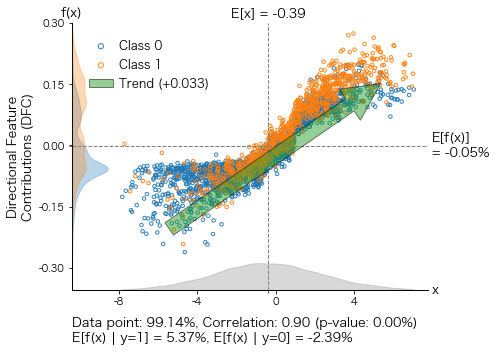

In [26]:
var = np.random.choice(list(X0))
var = "feature_15"
print(f"Feature name: {var}")
ax  = clf_explain.scatter(var, frac=0.3, by_class=False)

Directional feature contribution can be seen as an average incremental increase/decrease probability from bias. The scatter plot **`scatter()`** illustrates the relationship between $x$ and Directional Feature Contribution towards better understanding of how change in $x$ affects the prediction. The trend line is just a linear approximation and shall not be considered as a true relationship.

Feature name: feature_15


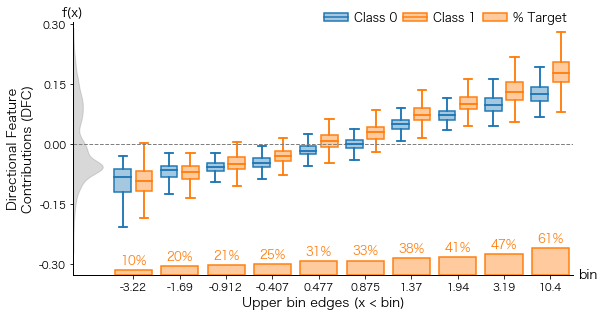

In [28]:
print(f"Feature name: {var}")
ax = clf_explain.boxplot(var, by_class=True)

In box plot **`boxplot()`**, Multi-Interval Discretization (modified) is applied to divide $x$ into bins towards monotonic trend (increase/decrease) of percentage of targets. This introduces a linear relationship between directional feature contribution and target, and enables us to understand in the most simplest way.

index: 5880


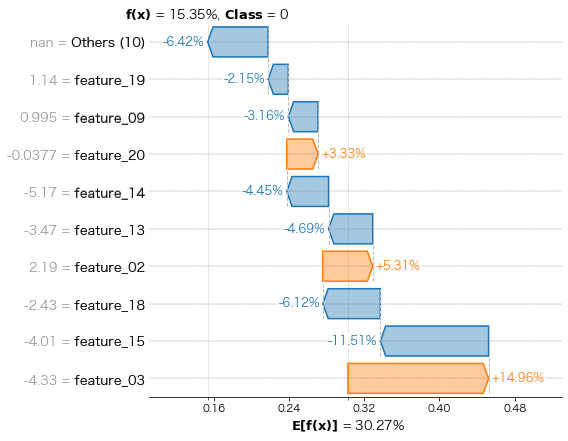

In [30]:
index = np.random.randint(len(X0))
print(f"index: {index}")
ax = clf_explain.waterfall(index=index, sort_by="contribution")

The prediction function can be expressed as $f(x) = \frac{1}{J}\sum_{j=1}^{J} c_{j} + \sum_{k=1}^{K} (\frac{1}{J}\sum_{j=1}^{J} contrib_{j}(x,k))$ where $J$ is the number of trees in the forest, $K$ is the number of features, $c_{j}$ is the value at the root of the node of $j^{th}$ tree (bias), and $contrib(x,k)$ is the contribution from the $k^{th}$ feature in the feature vector $x$. From the equation, Directional Feature Contributions, **DFC** always sum up to the difference between the average value at every root node and prediction. The simplest way to see this is through a waterfall plot **`waterfall()`** that starts from an average value of root nodes, and then adds contribution features one at a time until we reach the prediction.

In [186]:
df = pd.read_csv('test.txt', sep="|")

In [188]:
X = df.drop(columns=["ar_id", "key", "opn_mth", "main_cgy", 
                     "f60+M03", "fg", "f90+ever", 
                     "pos_dt", "sellr_st_f", 
                     "mbl_no_mtch_f", "cst_mtch_f", 
                     "ar_not_banned_f", "ident_no_mtch_f", 
                     "mgnd_sellr_f", "ip_id"]).copy()
y = df["fg"].values

In [129]:
cond = (X["mrch_age"]>=6) & (X["sum_nbr_ordr_l6m"]>0) & (X["ar_mtch_f"]=="Y")

In [130]:
X = X.loc[cond].reset_index(drop=True)
y = df["fg"].values[cond]

In [131]:
X

,mrch_rtg,mrch_age,nbr_fllwr,avg_gmv_l12m,sum_gmv,avg_gmv_l6m,max_gmv_l6m,max_gmv_l12m,sum_nbr_rvwr,sum_nbr_rvwr_l3m,...,avg_pyrl_amt,stbl_incm_amt,not_slry_ocp_f,sngl_ip_id_f,mx_incm_f,mx_mrch_age_f,mn_sellr_id_f,sellr_id_f,fnl_f,lmt_amt
0,4.9000,32.0000,NaN,"45,006.2500","704,212.0000","30,683.1700","56,400.0000","111,330.0000",79.0000,9.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"195,000.0000"
1,4.8900,18.0000,NaN,"101,178.0000","1,250,655.0000","117,248.8300","142,523.0000","142,523.0000",258.0000,77.0000,...,0.0000,"83,433.1000",N,Y,NaN,NaN,NaN,Y,Y,"500,000.0000"
2,4.9100,64.0000,NaN,190.7500,"18,574.0000",198.3300,"1,190.0000","1,190.0000",59.0000,0.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"55,000.0000"
3,4.7200,6.0000,NaN,"7,635.0000","100,651.0000","15,270.0000","30,444.0000","30,444.0000",126.0000,103.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"60,000.0000"
4,4.8400,64.0000,NaN,57.4200,"96,850.0000",76.0000,456.0000,456.0000,182.0000,0.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"121,000.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,4.7100,21.0000,NaN,"5,068.8300","60,826.0000","7,631.3300","17,892.0000","17,892.0000",178.0000,32.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"117,000.0000"
5005,5.0000,26.0000,NaN,628.8300,"7,546.0000","1,257.6700","7,546.0000","7,546.0000",1.0000,0.0000,...,0.0000,0.0000,Y,Y,NaN,NaN,NaN,Y,Y,"400,000.0000"
5006,4.8800,11.0000,NaN,545.3300,"6,544.0000",932.8300,"1,522.0000","1,522.0000",25.0000,12.0000,...,"13,658.3300",0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"100,000.0000"
5007,4.7500,39.0000,NaN,"22,341.5000","270,102.0000","7,556.1700","20,052.0000","92,323.0000",805.0000,1.0000,...,0.0000,0.0000,NaN,Y,NaN,NaN,NaN,Y,Y,"1,000,000.0000"


In [189]:
drop = []
for var in X.columns:
    if X[var].dtypes == 'object':
        drop += [var]
        X[var] = X[var].fillna("null")
        values = np.unique(X[var])
        for v in values:
            X[f"{var}_{v}"] = np.where(X[var]==v,1,0)
X = X.drop(columns=drop).fillna(-1)

In [194]:
sum(y)/len(y)

0.12065136935603257

In [209]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform


new_X = quantile_transform(X, n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

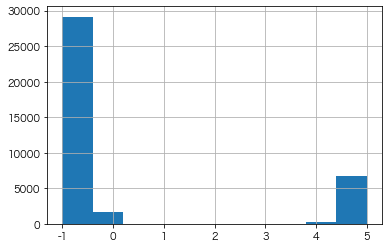

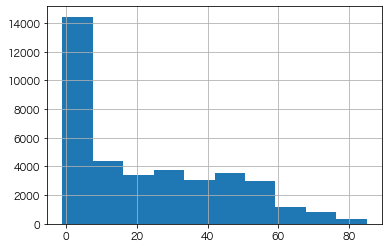

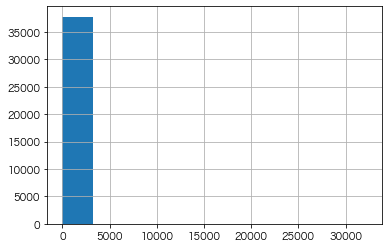

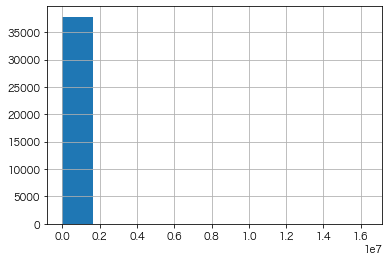

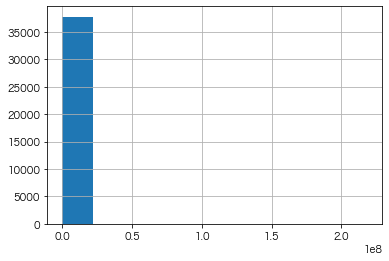

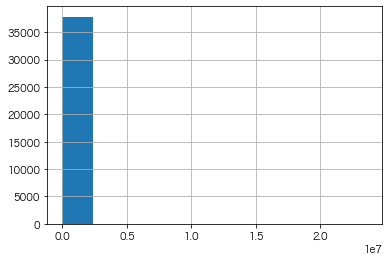

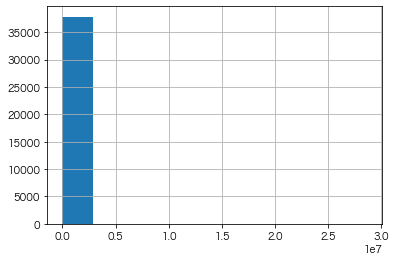

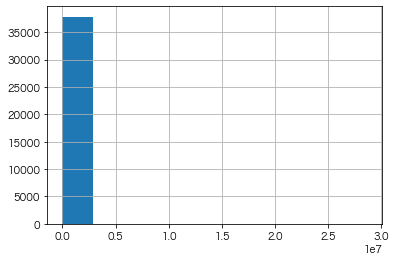

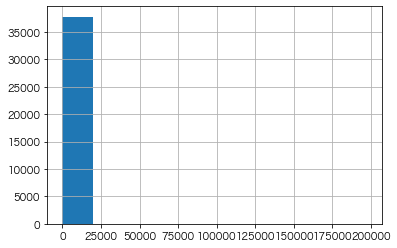

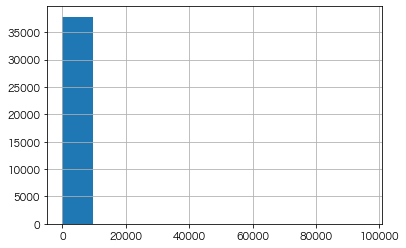

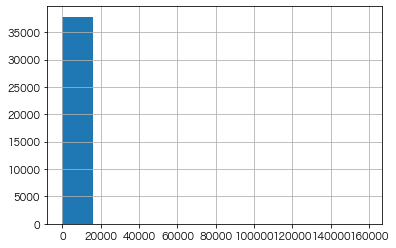

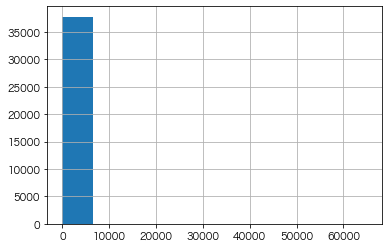

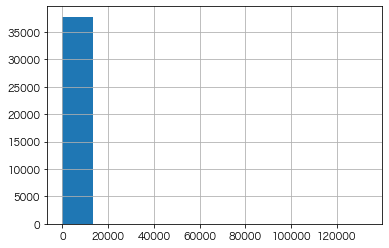

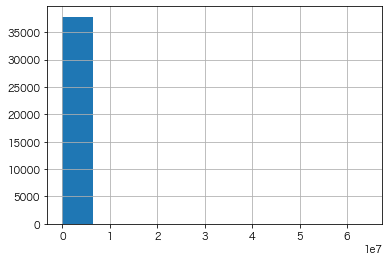

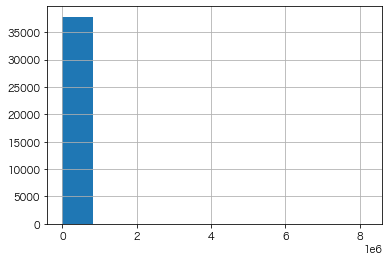

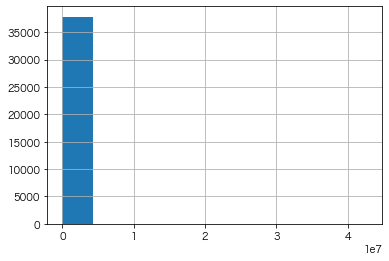

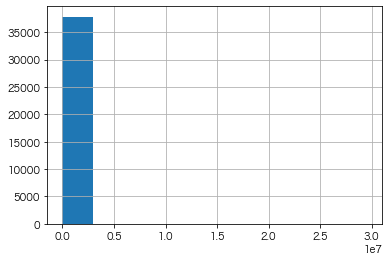

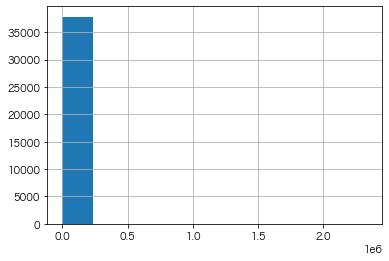

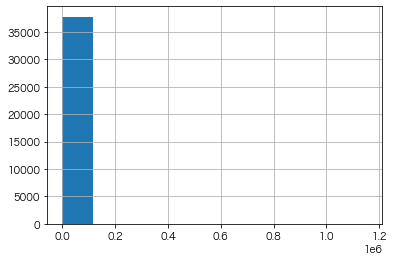

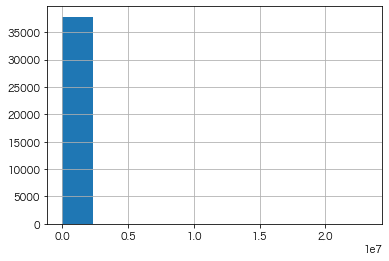

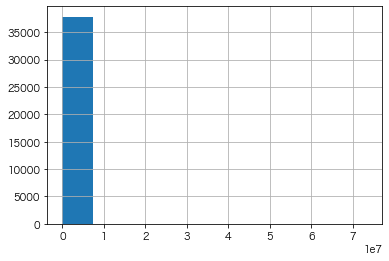

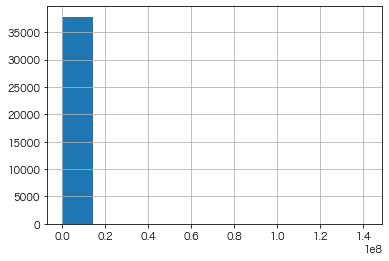

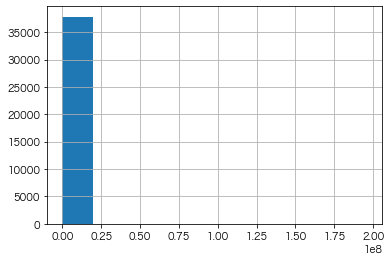

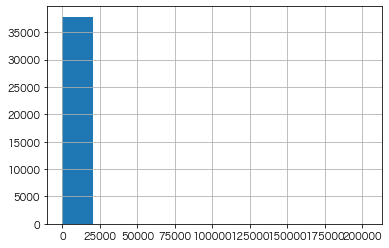

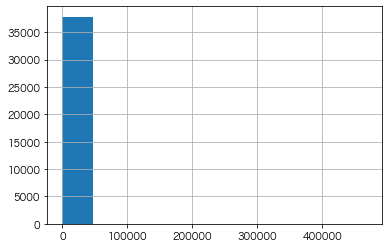

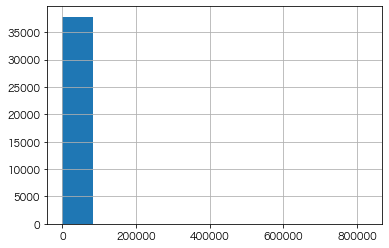

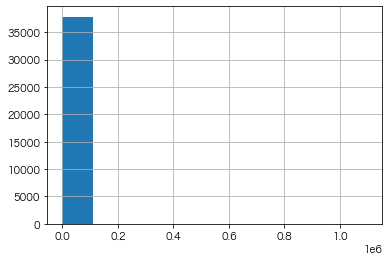

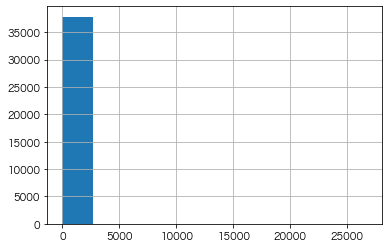

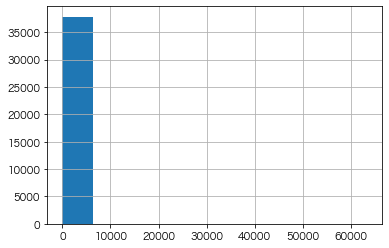

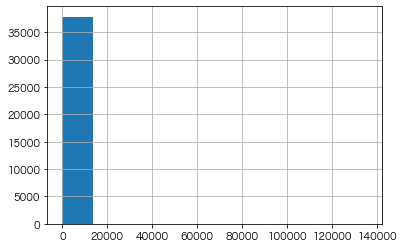

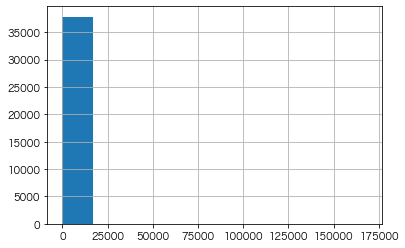

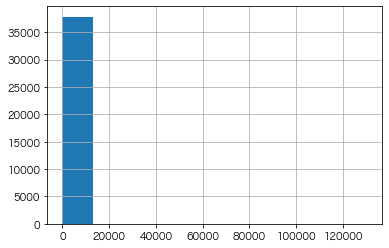

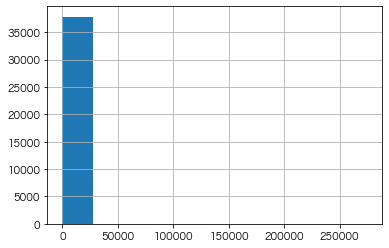

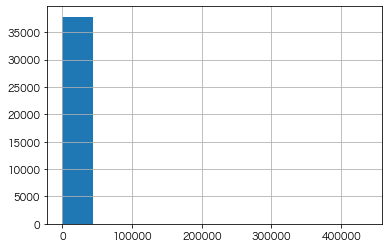

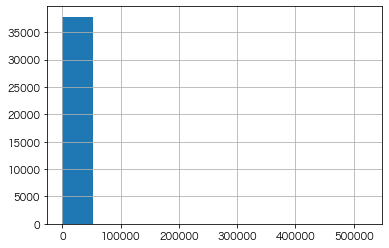

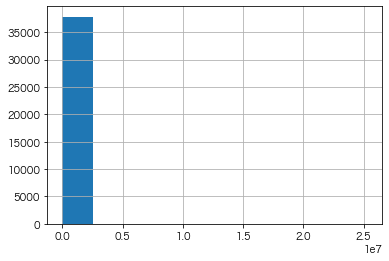

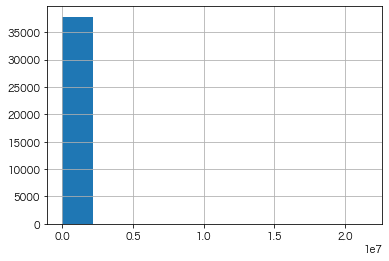

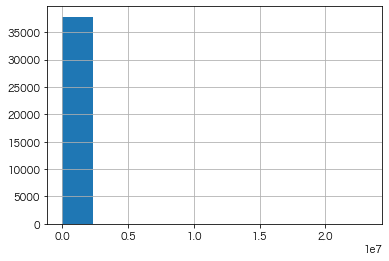

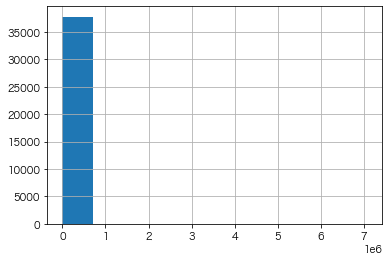

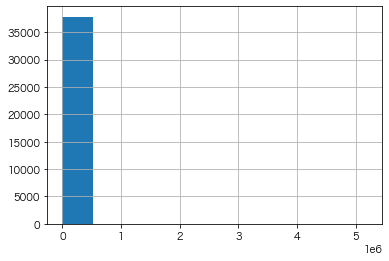

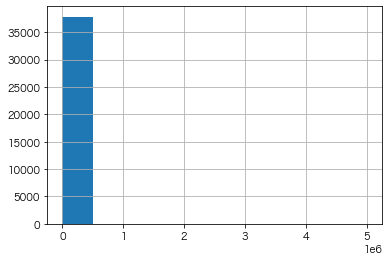

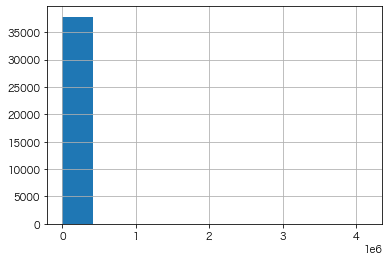

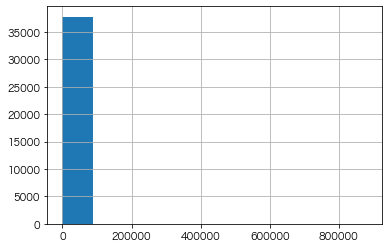

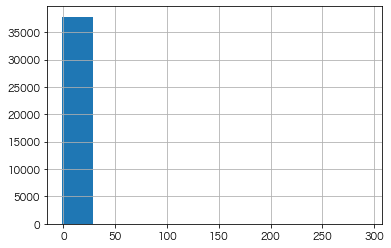

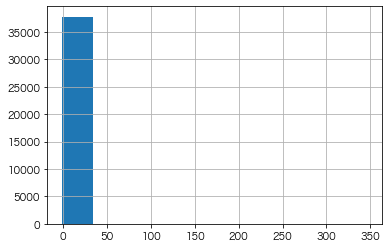

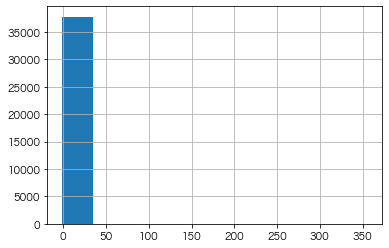

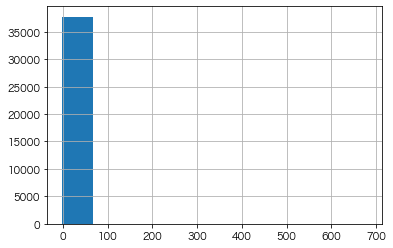

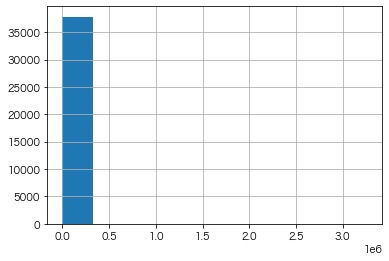

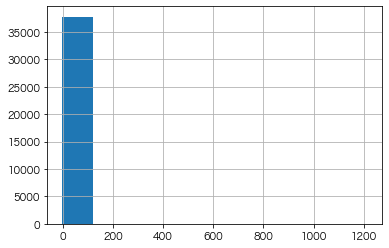

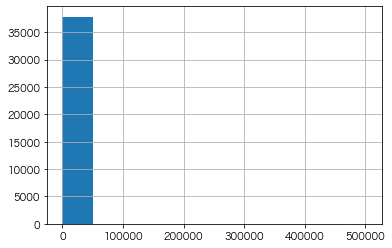

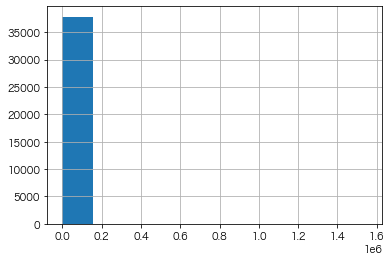

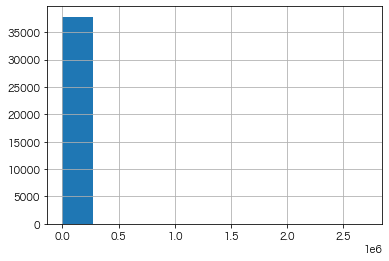

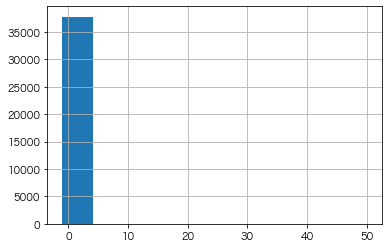

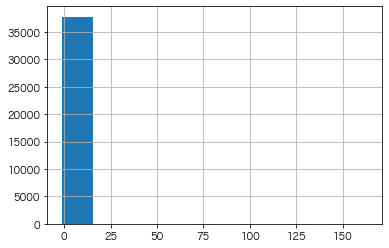

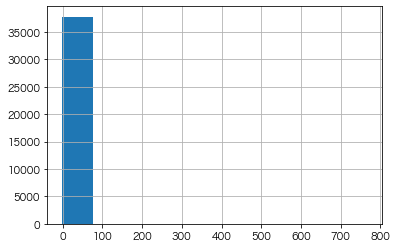

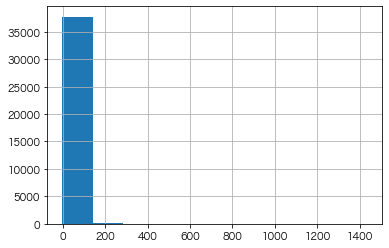

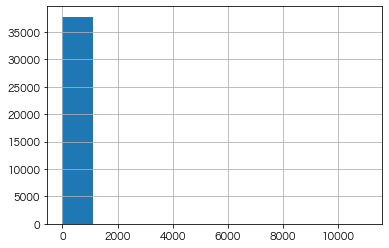

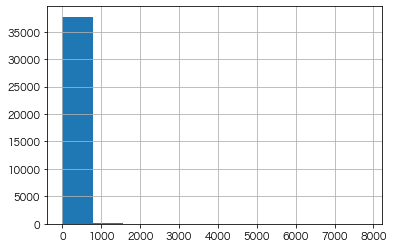

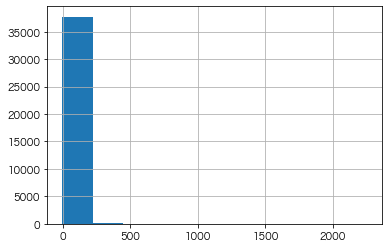

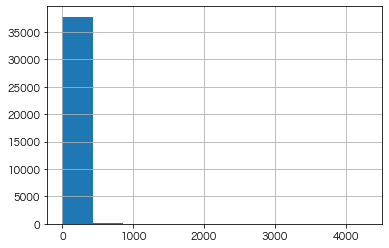

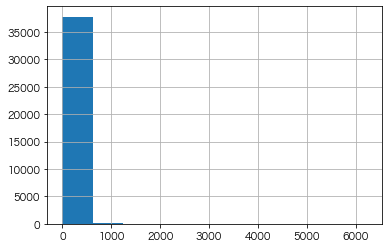

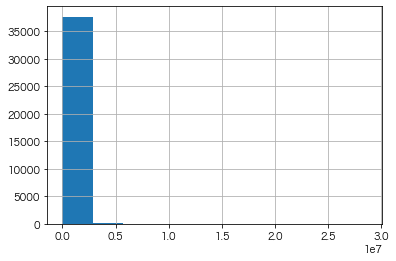

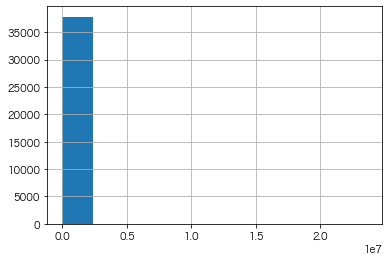

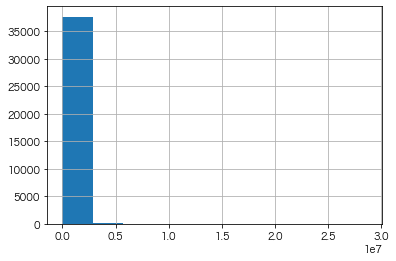

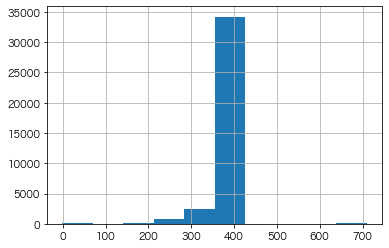

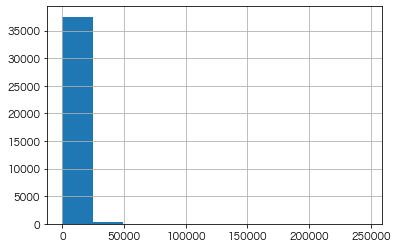

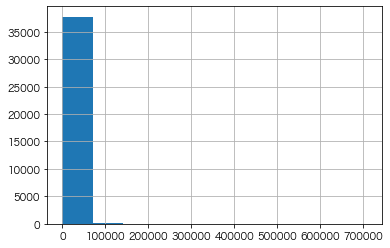

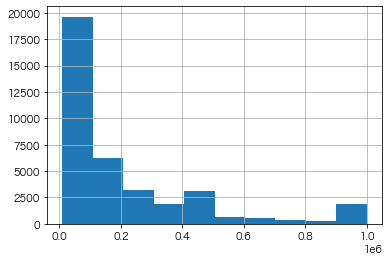

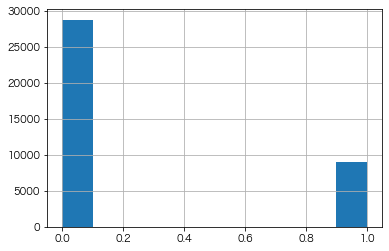

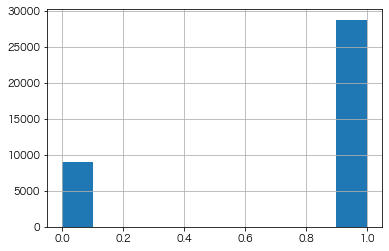

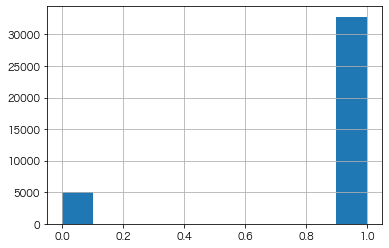

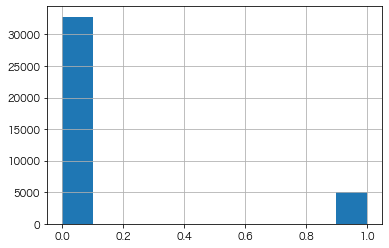

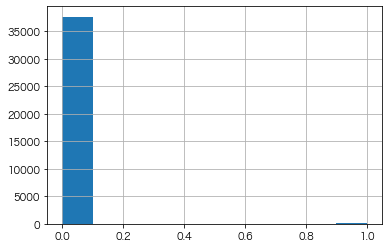

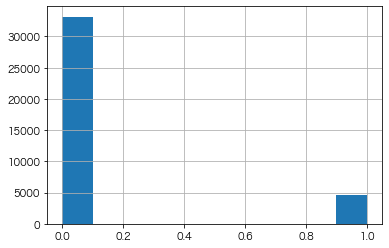

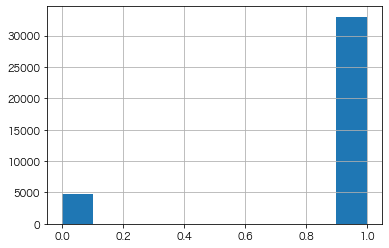

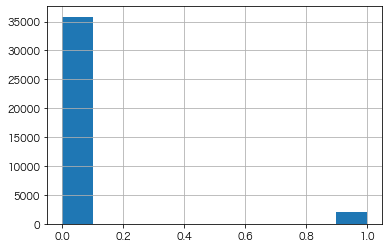

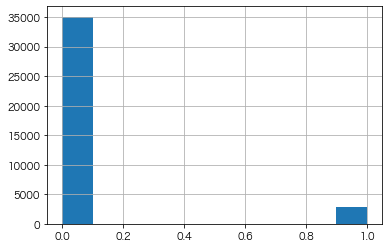

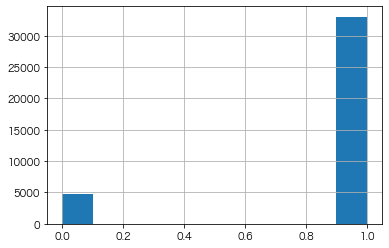

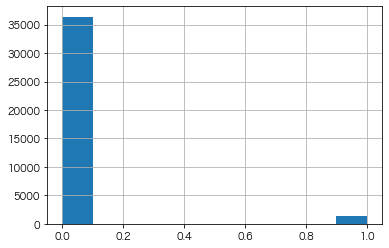

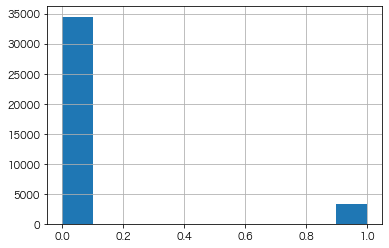

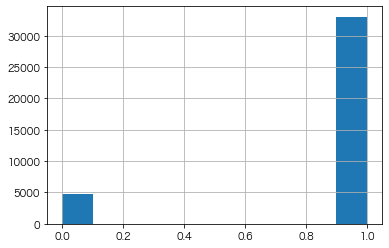

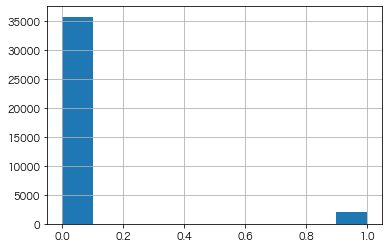

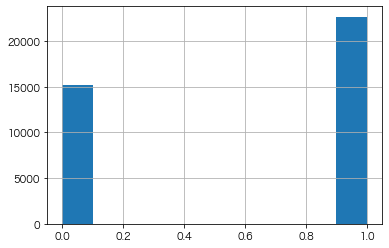

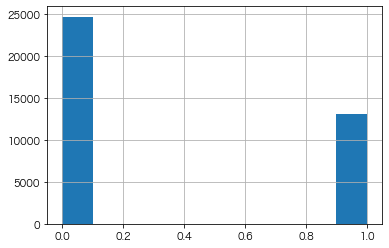

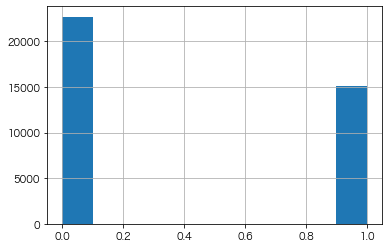

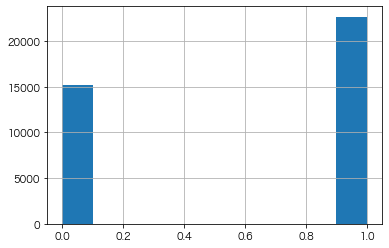

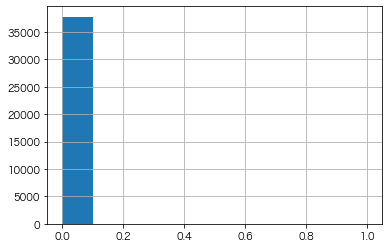

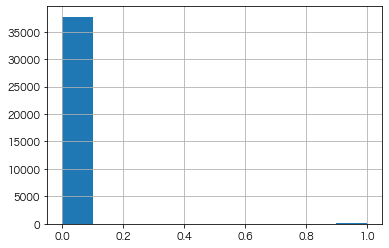

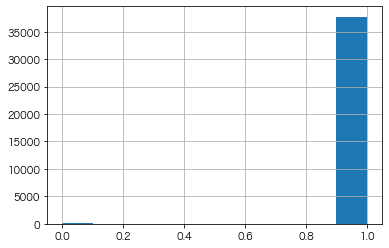

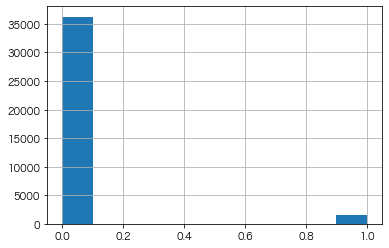

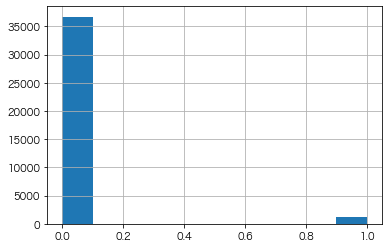

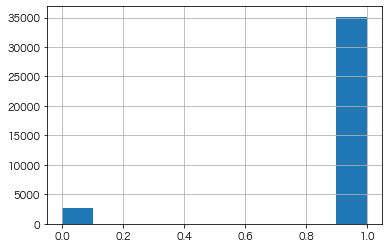

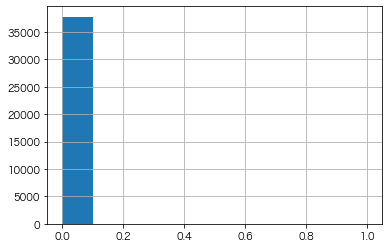

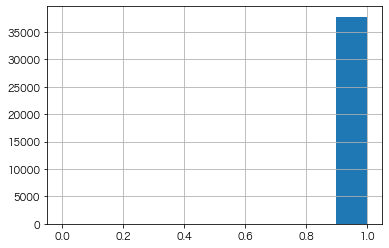

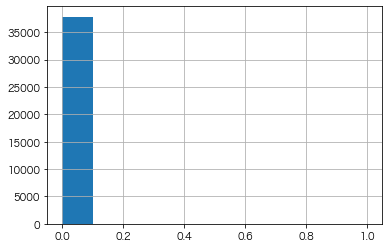

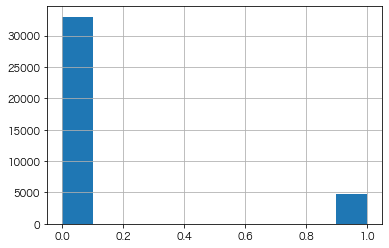

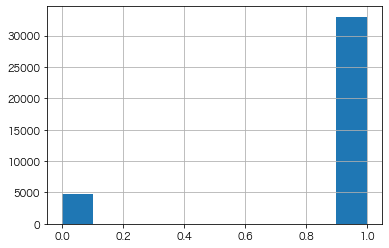

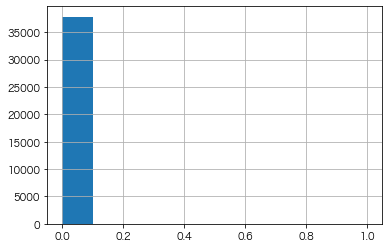

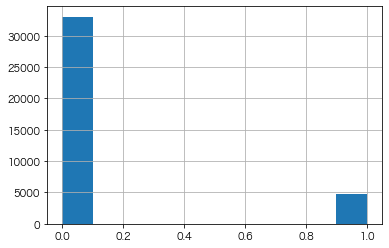

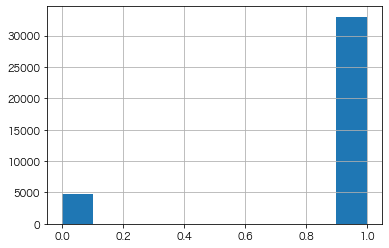

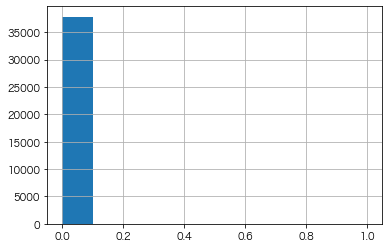

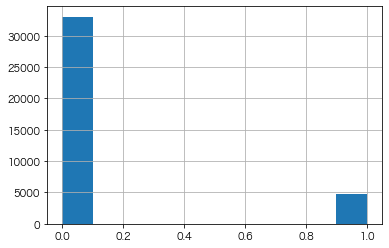

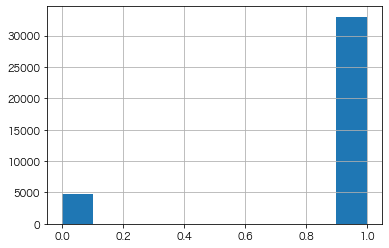

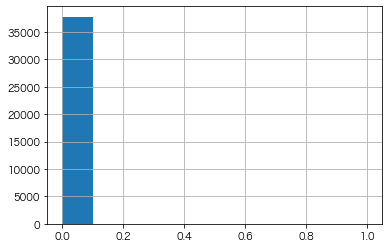

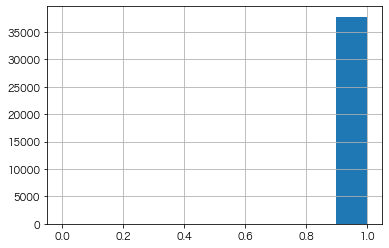

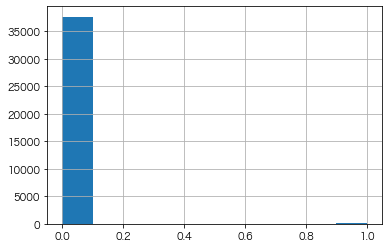

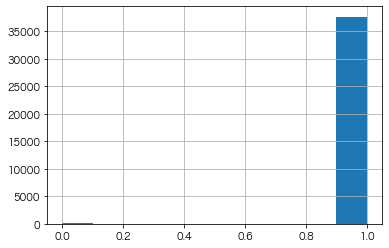

In [213]:
for var in list(X):
    X[var].hist(bins=10)
    plt.show()

In [214]:
dok = dict()
for var in list(X):
    try:
        x = X[var].values
        a = MultiInterval(y, x, criterion="gini", equal_width=False, bins=10, 
                          min_pct=0.01, min_cls=0.01, trend="auto")
        dok[var] = a
    except: pass
print("Complete")

Complete


In [202]:
dok["nbr_fllwr"]

Results(woe=array([-0.01527628,  2.90595076]), iv=array([0.00023139, 0.04401616]), target=array([0.503819  , 0.05186018]), bin_edges=array([-1.00000000e+00,  1.23334303e+01,  3.25725000e+04]))

mrch_rtg
[-1.    0.    5.05]


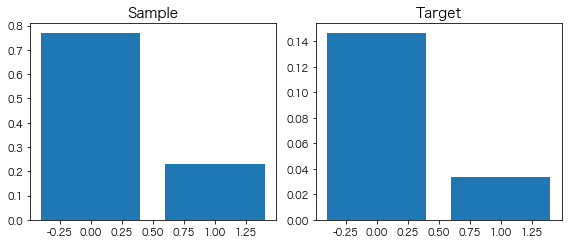

----------------------------------------------------------------------------------------------------
mrch_age
[-1.    2.    4.    7.   12.   15.   18.   24.   28.   36.   43.   45.
 47.   66.   85.85]


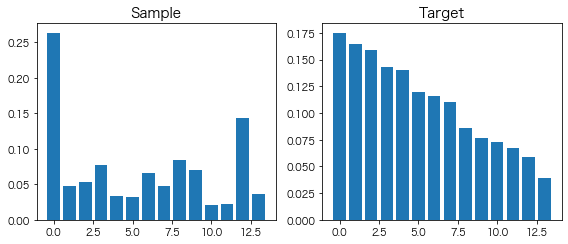

----------------------------------------------------------------------------------------------------
nbr_fllwr
[-1.00000000e+00  1.23334303e+01  3.25725000e+04]


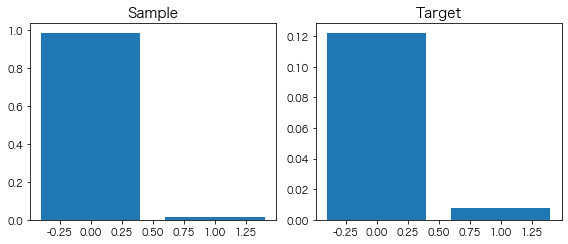

----------------------------------------------------------------------------------------------------
avg_gmv_l12m
[-1.0000000e+00  5.6623000e+02  1.6492727e+07]


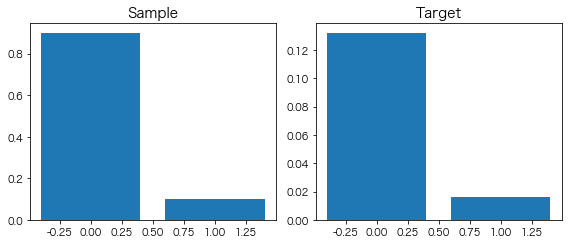

----------------------------------------------------------------------------------------------------
sum_gmv
[-1.00000000e+00  1.75000000e+02  3.35000000e+02  2.27540000e+03
  2.86962000e+04  2.20376974e+08]


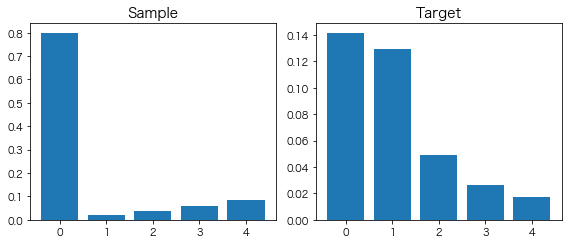

----------------------------------------------------------------------------------------------------
avg_gmv_l6m
[-1.00000000e+00  5.54650000e+02  2.38235829e+07]


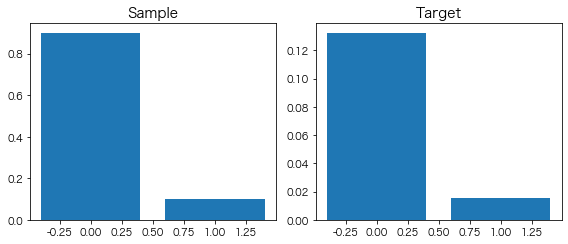

----------------------------------------------------------------------------------------------------
max_gmv_l6m
[-1.00000000e+00  2.02630000e+03  2.89091977e+07]


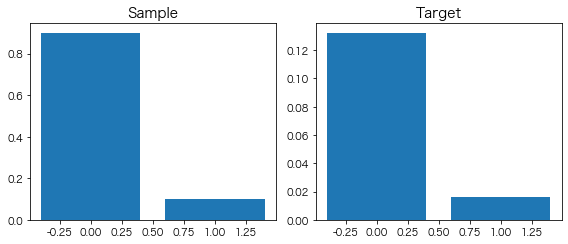

----------------------------------------------------------------------------------------------------
max_gmv_l12m
[-1.00000000e+00  3.18150000e+03  2.89091977e+07]


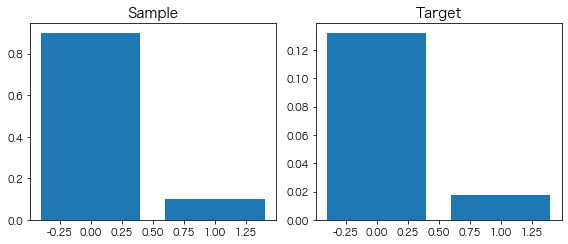

----------------------------------------------------------------------------------------------------
sum_nbr_rvwr
[-1.00000e+00  2.60000e+01  1.99273e+05]


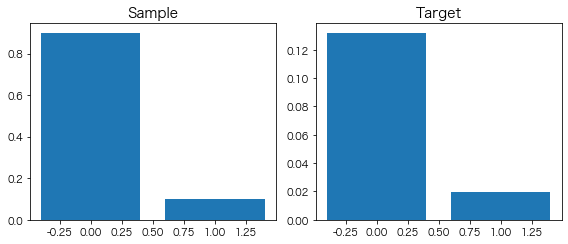

----------------------------------------------------------------------------------------------------
sum_nbr_rvwr_l3m
[-1.000000e+00  2.000000e+00  9.700747e+04]


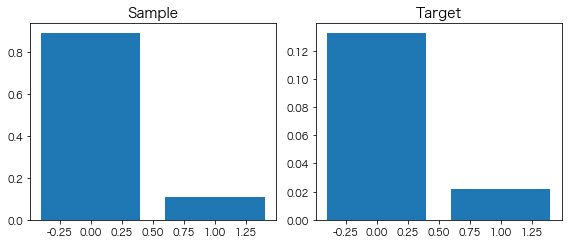

----------------------------------------------------------------------------------------------------
sum_nbr_rvwr_l6m
[-1.0000000e+00  4.0000000e+00  1.6033043e+05]


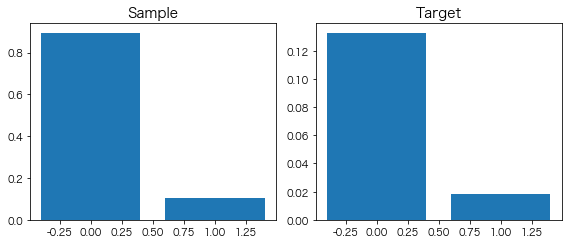

----------------------------------------------------------------------------------------------------
sum_nbr_fllwr_l3m
[-1.000000e+00  0.000000e+00  2.000000e+00  3.000000e+00  5.000000e+00
  8.000000e+00  6.564495e+04]


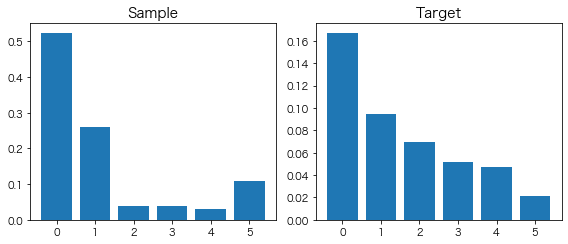

----------------------------------------------------------------------------------------------------
sum_nbr_fllwr_l6m
[-1.0000000e+00  0.0000000e+00  2.0000000e+00  4.0000000e+00
  8.0000000e+00  1.5000000e+01  1.3453705e+05]


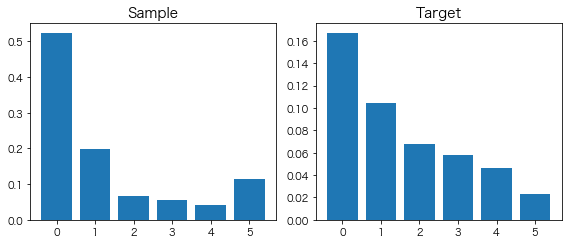

----------------------------------------------------------------------------------------------------
sum_gmv_airpay_l6m
[-1.00000000e+00  8.64300000e+02  6.48078893e+07]


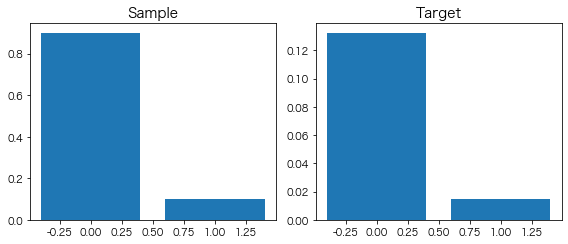

----------------------------------------------------------------------------------------------------
sum_gmv_atm_l6m
[-1.0000000e+00  2.0400000e+02  8.2683448e+06]


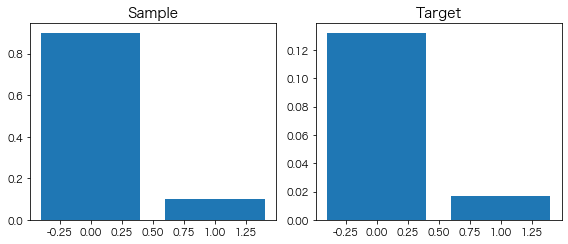

----------------------------------------------------------------------------------------------------
sum_gmv_cod_l6m
[-1.00000000e+00  2.04300000e+02  4.30978039e+07]


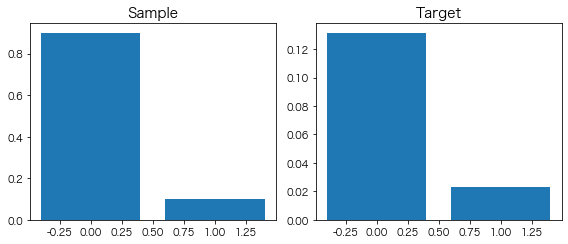

----------------------------------------------------------------------------------------------------
sum_gmv_cc_l6m
[-1.0000000e+00  2.9800000e+02  2.9810955e+07]


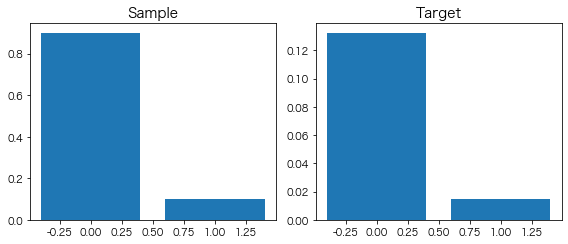

----------------------------------------------------------------------------------------------------
sum_gmv_ib_l6m
[-1.00000000e+00  7.72818521e+02  2.35764906e+06]


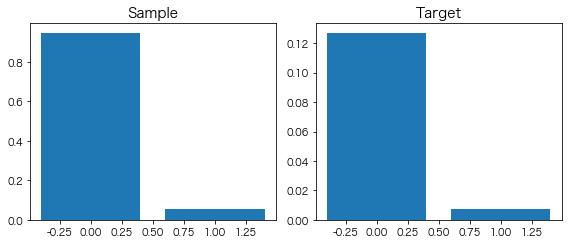

----------------------------------------------------------------------------------------------------
sum_gmv_othr_l6m
[-1.00000000e+00  3.66194221e+02  1.16455323e+06]


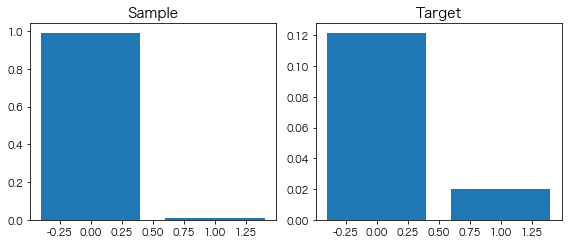

----------------------------------------------------------------------------------------------------
sum_gmv_l1m
[-1.00000000e+00  2.65000000e+02  2.33850845e+07]


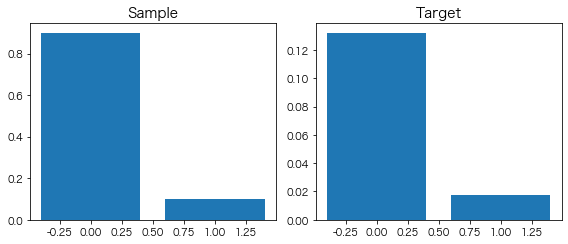

----------------------------------------------------------------------------------------------------
sum_gmv_l3m
[-1.00000000e+00  1.22860000e+03  7.40503003e+07]


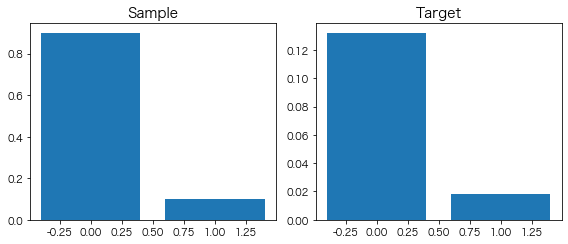

----------------------------------------------------------------------------------------------------
sum_gmv_l6m
[-1.00000000e+00  2.59620000e+03  1.42941497e+08]


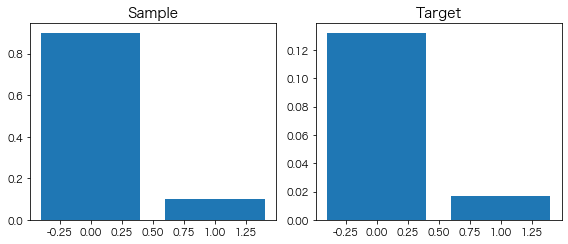

----------------------------------------------------------------------------------------------------
sum_gmv_l12m
[-1.00000000e+00  5.27430000e+03  1.97912724e+08]


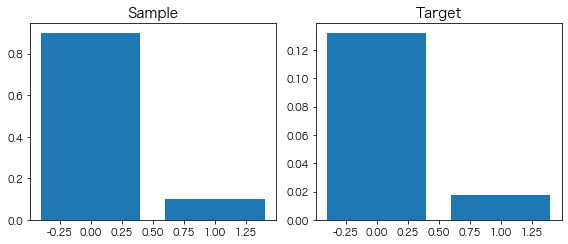

----------------------------------------------------------------------------------------------------
sum_nbr_ordr_l1m
[-1.0000000e+00  1.0000000e+00  2.0000000e+00  2.0493203e+05]


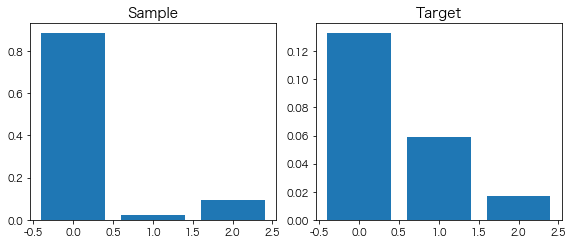

----------------------------------------------------------------------------------------------------
sum_nbr_ordr_l3m
[-1.0000000e+00  4.0000000e+00  4.7284968e+05]


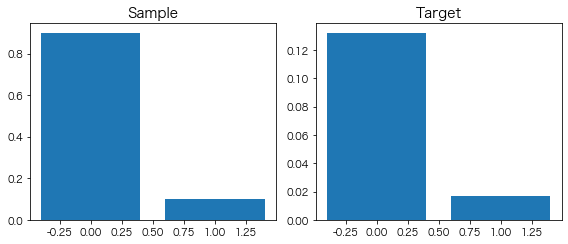

----------------------------------------------------------------------------------------------------
sum_nbr_ordr_l6m
[-1.0000000e+00  7.0000000e+00  8.3453977e+05]


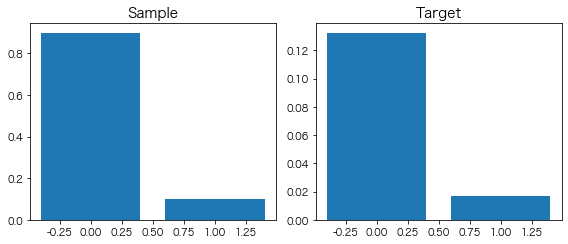

----------------------------------------------------------------------------------------------------
sum_nbr_ordr_l12m
[-1.00000000e+00  1.40000000e+01  1.10751247e+06]


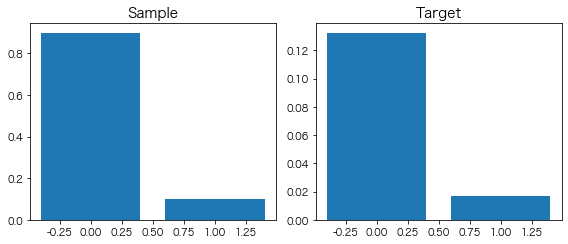

----------------------------------------------------------------------------------------------------
sum_nbr_cncl_ordr_l1m
[-1.000000e+00  0.000000e+00  2.000000e+00  2.696498e+04]


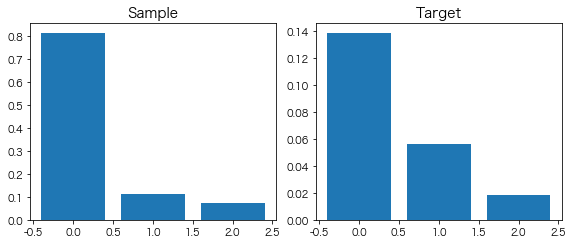

----------------------------------------------------------------------------------------------------
sum_nbr_cncl_ordr_l3m
[-1.000000e+00  2.000000e+00  5.000000e+00  6.395926e+04]


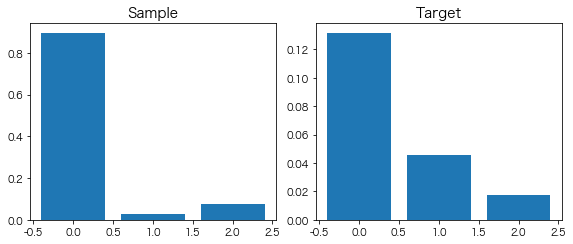

----------------------------------------------------------------------------------------------------
sum_nbr_cncl_ordr_l6m
[-1.000000e+00  3.000000e+00  9.000000e+00  1.366833e+05]


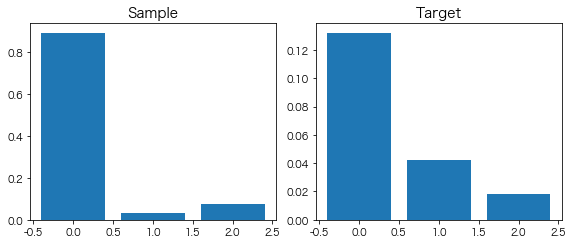

----------------------------------------------------------------------------------------------------
sum_nbr_cncl_ordr_l12m
[-1.0000000e+00  6.0000000e+00  1.7003653e+05]


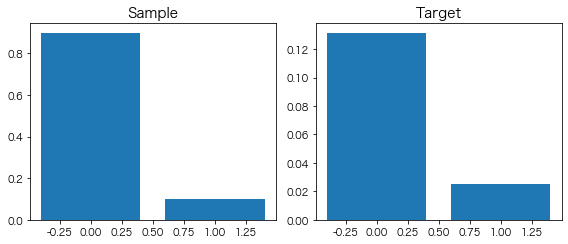

----------------------------------------------------------------------------------------------------
sum_nbr_buyr_l1m
[-1.0000000e+00  1.0000000e+00  3.0000000e+00  1.3150503e+05]


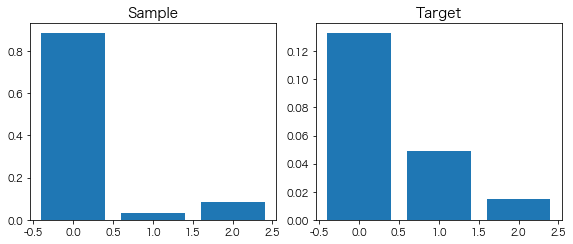

----------------------------------------------------------------------------------------------------
sum_nbr_buyr_l3m
[-1.0000000e+00  3.0000000e+00  2.7721066e+05]


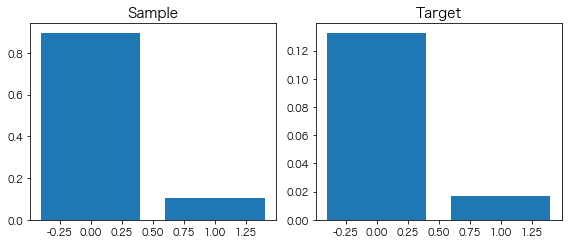

----------------------------------------------------------------------------------------------------
sum_nbr_buyr_l6m
[-1.0000000e+00  6.0000000e+00  4.4115386e+05]


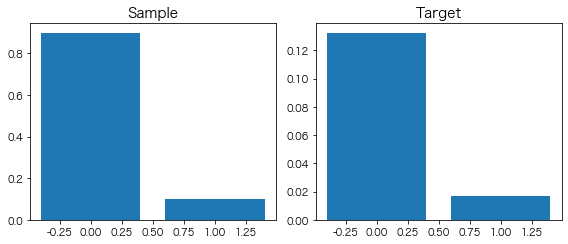

----------------------------------------------------------------------------------------------------
sum_nbr_buyr_l12m
[-1.0000000e+00  1.2000000e+01  5.2767854e+05]


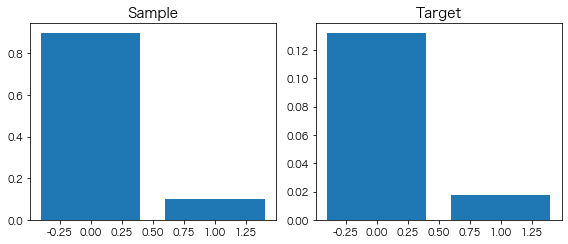

----------------------------------------------------------------------------------------------------
sum_gmv_sep
[-1.00000000e+00  0.00000000e+00  1.82000000e+02  2.55178389e+07]


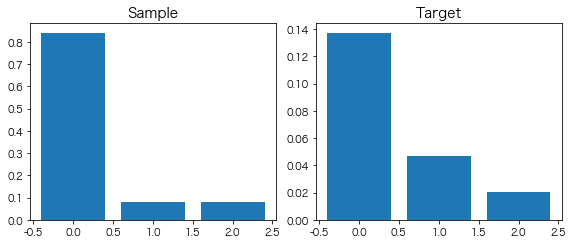

----------------------------------------------------------------------------------------------------
sum_gmv_nov
[-1.00000000e+00  0.00000000e+00  1.24000000e+02  2.17560181e+07]


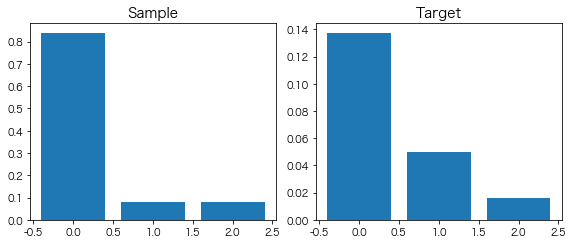

----------------------------------------------------------------------------------------------------
sum_gmv_dec
[-1.00000000e+00  0.00000000e+00  1.14000000e+02  2.33850845e+07]


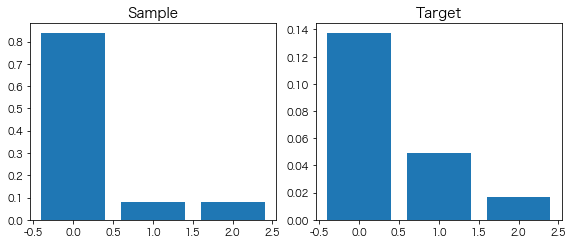

----------------------------------------------------------------------------------------------------
sum_gmv_mar
[-1.00000000e+00  0.00000000e+00  7.13797603e+06]


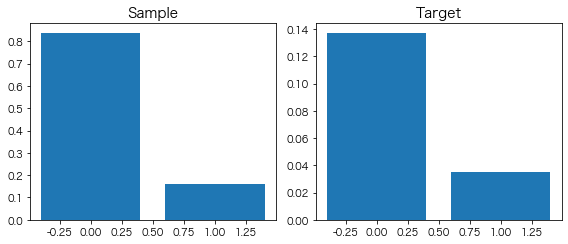

----------------------------------------------------------------------------------------------------
sum_gmv_9sep
[-1.00000000e+00  7.76426615e+02  5.24062538e+06]


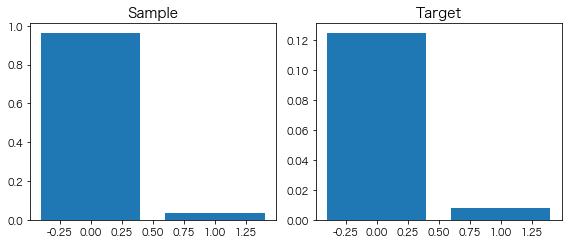

----------------------------------------------------------------------------------------------------
sum_gmv_11nov
[-1.00000000e+00  7.28494131e+02  5.05005656e+06]


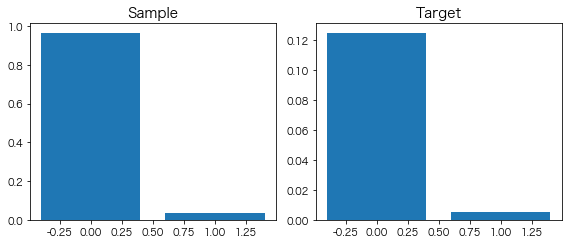

----------------------------------------------------------------------------------------------------
sum_gmv_12dec
[-1.00000000e+00  6.29726102e+02  4.18906590e+06]


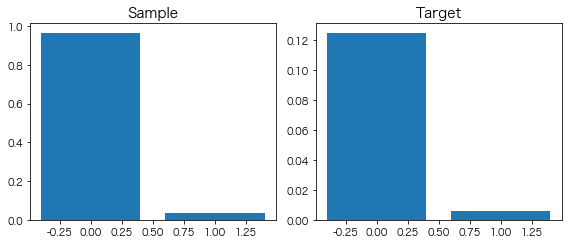

----------------------------------------------------------------------------------------------------
sum_gmv_3mar
[-1.00000000e+00  3.60455113e+02  8.89746370e+05]


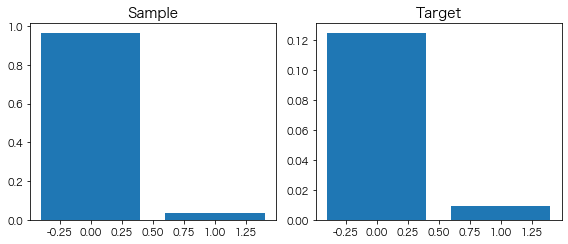

----------------------------------------------------------------------------------------------------
sum_nbr_cmpn_l1m
[ -1.          -0.87006979 295.93      ]


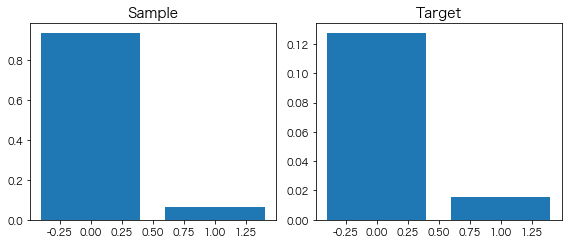

----------------------------------------------------------------------------------------------------
sum_nbr_cmpn_l3m
[ -1.          -0.74851962 349.46      ]


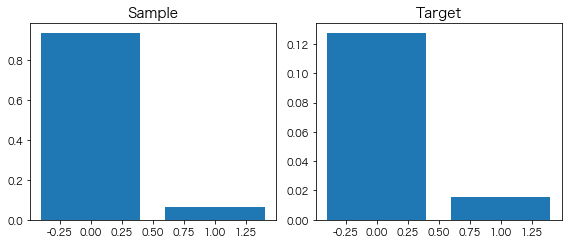

----------------------------------------------------------------------------------------------------
sum_nbr_cmpn_l6m
[ -1.          -0.61216559 358.55      ]


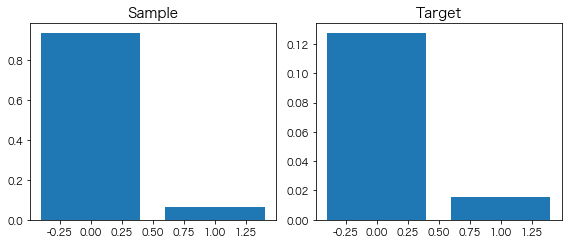

----------------------------------------------------------------------------------------------------
sum_nbr_cmpn_l12m
[-1.00000000e+00 -1.52162419e-01  6.85790000e+02]


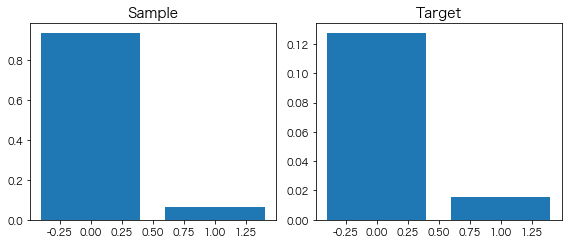

----------------------------------------------------------------------------------------------------
sum_nbr_qty
[-1.00000000e+00  1.00000000e+00  2.00000000e+00  2.00000000e+01
  1.99000000e+02  3.29155162e+06]


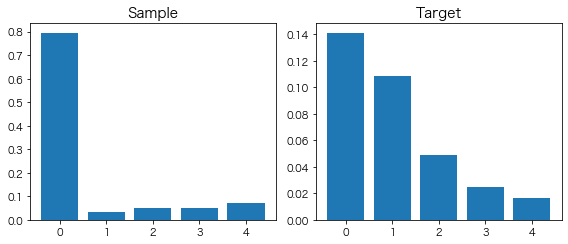

----------------------------------------------------------------------------------------------------
sum_nbr_ret_qty
[-1.00000000e+00 -4.14745691e-01  1.22412000e+03]


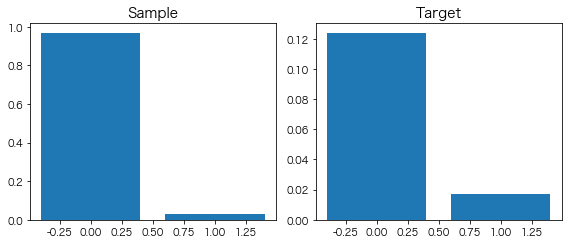

----------------------------------------------------------------------------------------------------
sum_nbr_qty_l1m
[-1.00000e+00  1.00000e+00  5.00000e+00  5.07323e+05]


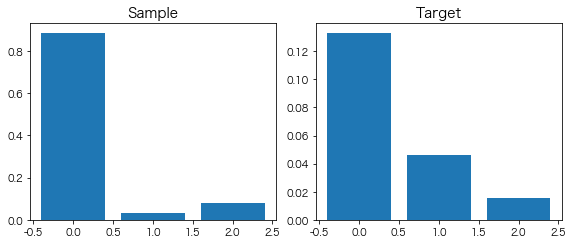

----------------------------------------------------------------------------------------------------
sum_nbr_qty_l3m
[-1.00000000e+00  5.00000000e+00  1.56555555e+06]


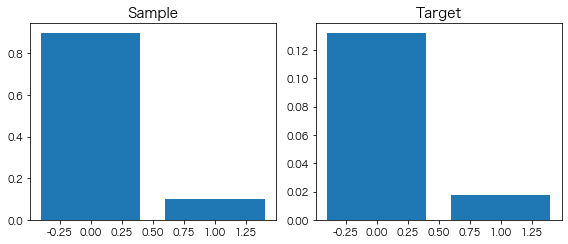

----------------------------------------------------------------------------------------------------
sum_nbr_qty_l6m
[-1.00000000e+00  1.00000000e+01  2.73507293e+06]


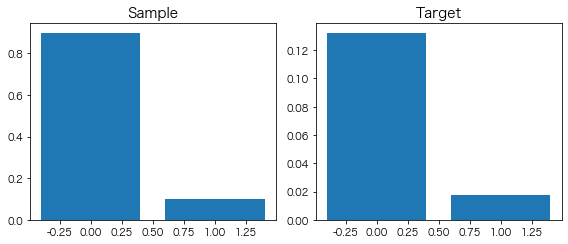

----------------------------------------------------------------------------------------------------
sum_nbr_ret_l1m
[-1.        -0.9820239 50.5      ]


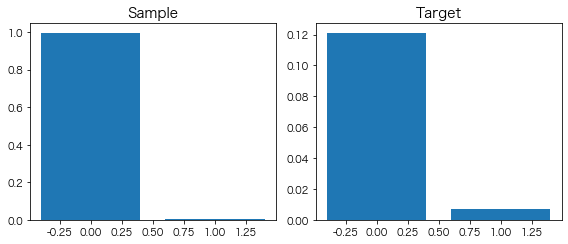

----------------------------------------------------------------------------------------------------
sum_nbr_ret_l3m
[ -1.          -0.93605266 164.63      ]


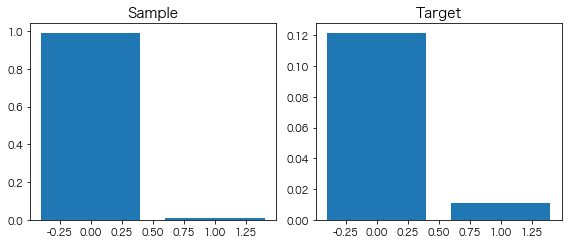

----------------------------------------------------------------------------------------------------
sum_nbr_ret_l6m
[ -1.          -0.77971344 773.66      ]


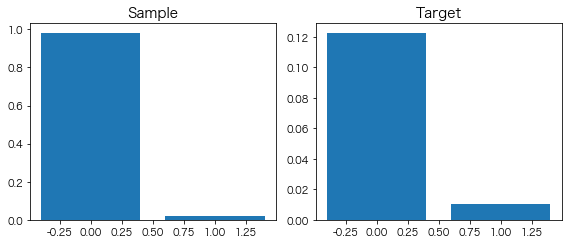

----------------------------------------------------------------------------------------------------
avg_nbr_sku_l3m
[-1.00000e+00  0.00000e+00  1.00000e+00  1.44733e+03]


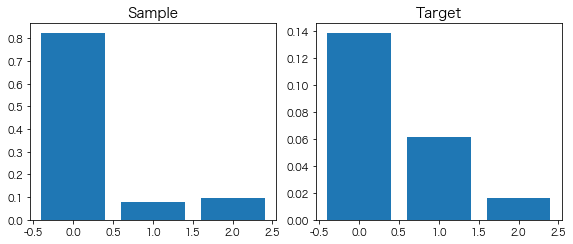

----------------------------------------------------------------------------------------------------
sum_nbr_sku_list_l1m
[-1.000000e+00  8.000000e+00  1.115646e+04]


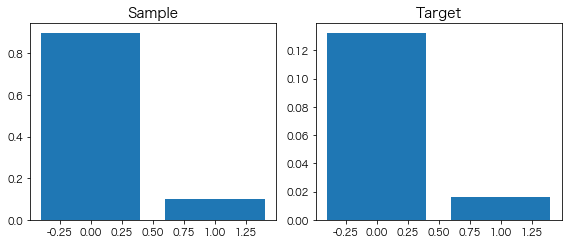

----------------------------------------------------------------------------------------------------
sum_nbr_sku_sold_l12m
[-1.00000e+00  6.00000e+00  7.90729e+03]


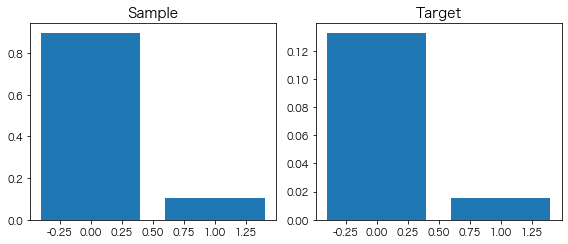

----------------------------------------------------------------------------------------------------
sum_nbr_sku_sold_l1m
[-1.0000e+00  1.0000e+00  2.0000e+00  2.2725e+03]


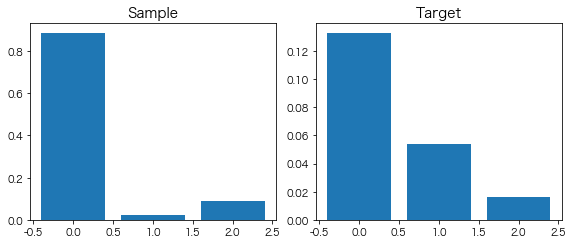

----------------------------------------------------------------------------------------------------
sum_nbr_sku_sold_l3m
[-1.000e+00  2.000e+00  4.343e+03]


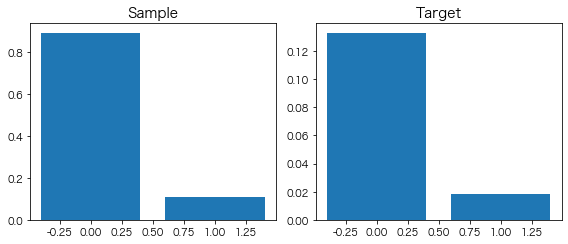

----------------------------------------------------------------------------------------------------
sum_nbr_sku_sold_l6m
[-1.00000e+00  4.00000e+00  6.29028e+03]


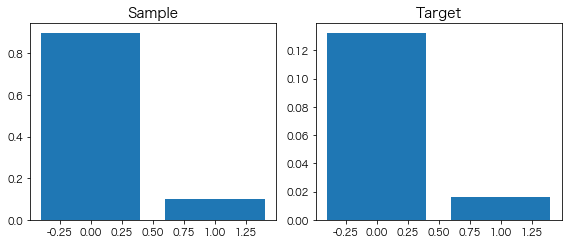

----------------------------------------------------------------------------------------------------
incm_amt
[0.00000000e+00 1.05091260e+04 1.92893840e+04 2.12256700e+04
 4.94904800e+04 5.50997820e+04 5.69166000e+04 5.98644700e+04
 2.89437041e+07]


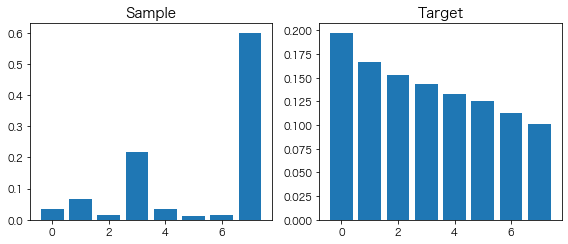

----------------------------------------------------------------------------------------------------
shopee_incm_amt
[0.00000000e+00 5.54650000e+02 2.38235829e+07]


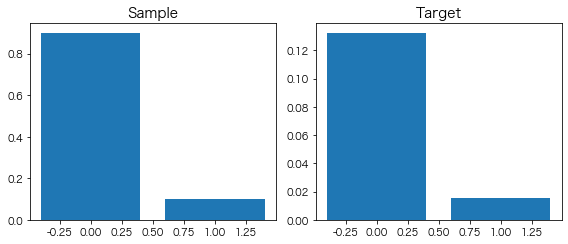

----------------------------------------------------------------------------------------------------
est_incm_amt
[0.00000000e+00 1.13415760e+04 1.94657600e+04 4.85239650e+04
 5.28568300e+04 2.89437041e+07]


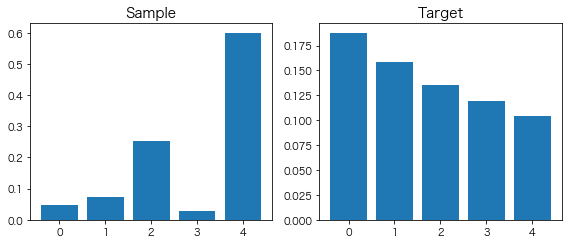

----------------------------------------------------------------------------------------------------
mx_nbr_dys_ar_opn
[ -1.  311.  346.  356.  717.1]


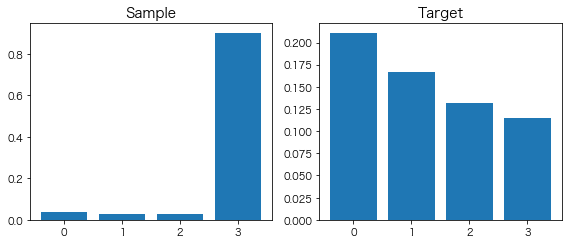

----------------------------------------------------------------------------------------------------
avg_pyrl_amt
[     0.           1172.24347864 249217.5       ]


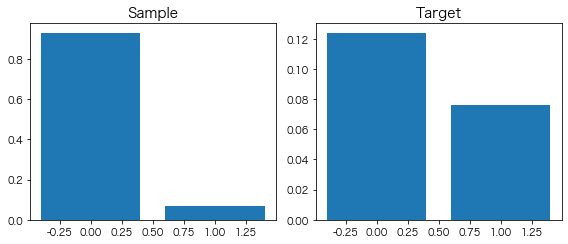

----------------------------------------------------------------------------------------------------
stbl_incm_amt
[     0.           1321.57575235 714728.0958    ]


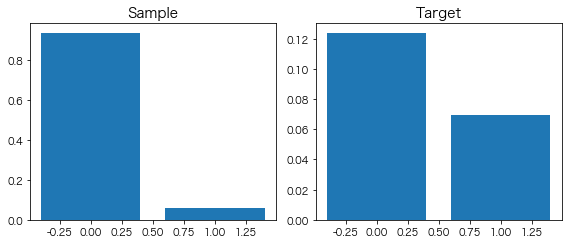

----------------------------------------------------------------------------------------------------
lmt_amt
[  10000.  100000. 1010000.]


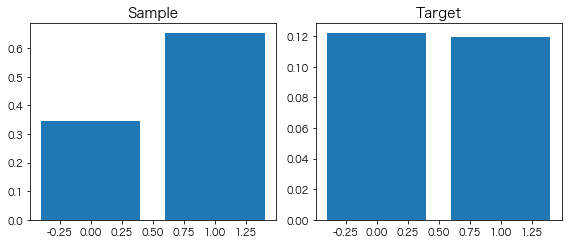

----------------------------------------------------------------------------------------------------
bnk_KBank
[0.        0.2387385 1.01     ]


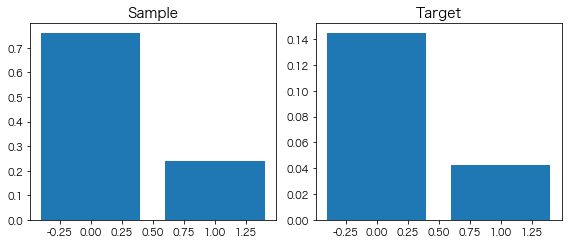

----------------------------------------------------------------------------------------------------
bnk_non-KBank
[0.   1.   1.01]


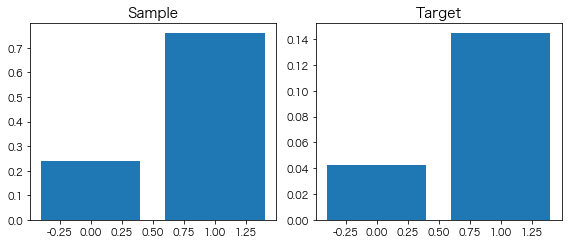

----------------------------------------------------------------------------------------------------
mrch_incm_f_N
[0.   1.   1.01]


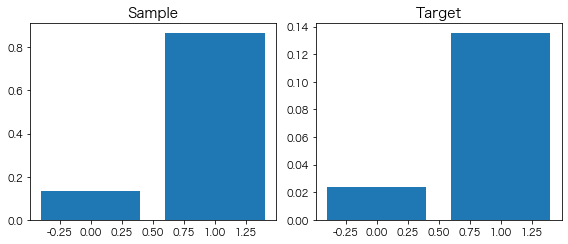

----------------------------------------------------------------------------------------------------
mrch_incm_f_Y
[0.         0.13304959 1.01      ]


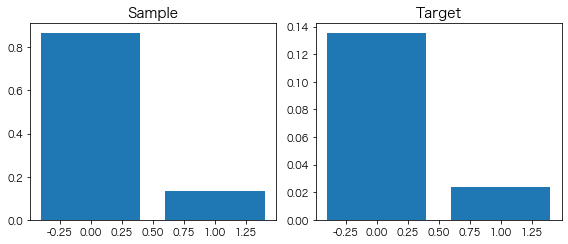

----------------------------------------------------------------------------------------------------
nm_mtch_f_N
[0.         0.00367453 1.01      ]


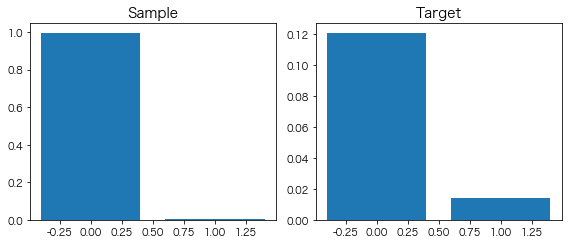

----------------------------------------------------------------------------------------------------
nm_mtch_f_Y
[0.         0.12345353 1.01      ]


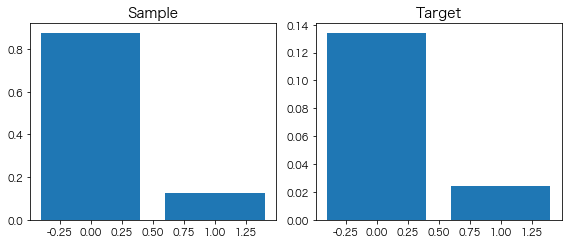

----------------------------------------------------------------------------------------------------
nm_mtch_f_null
[0.   1.   1.01]


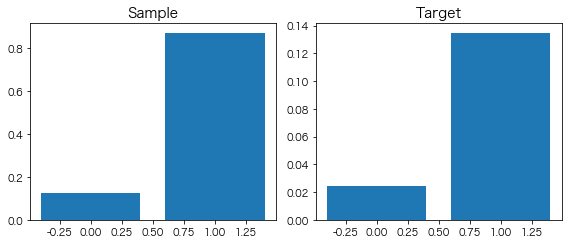

----------------------------------------------------------------------------------------------------
ar_st_f_N
[0.         0.05273871 1.01      ]


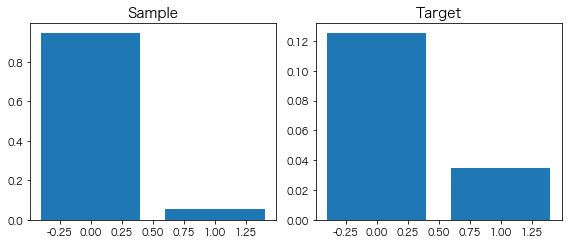

----------------------------------------------------------------------------------------------------
ar_st_f_Y
[0.         0.07370202 1.01      ]


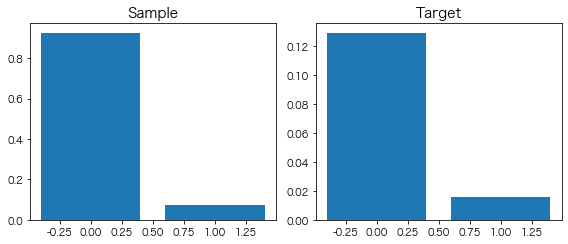

----------------------------------------------------------------------------------------------------
ar_st_f_null
[0.   1.   1.01]


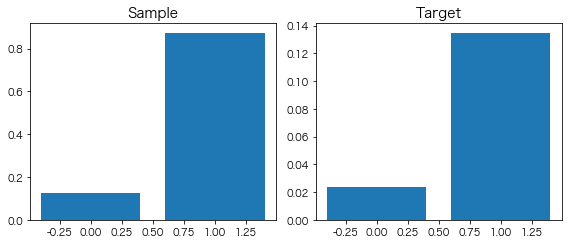

----------------------------------------------------------------------------------------------------
ar_tp_f_N
[0.         0.03788199 1.01      ]


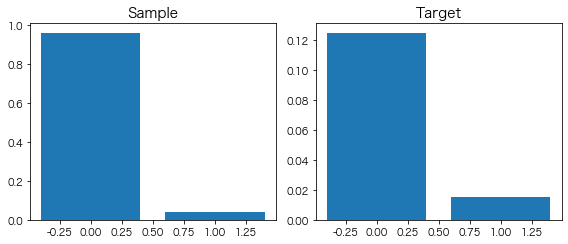

----------------------------------------------------------------------------------------------------
ar_tp_f_Y
[0.         0.08855874 1.01      ]


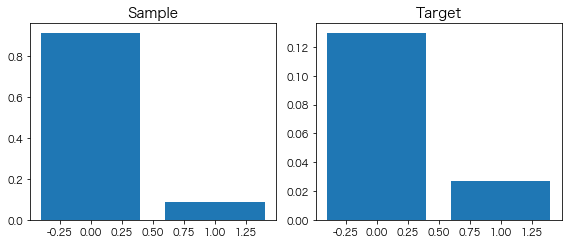

----------------------------------------------------------------------------------------------------
ar_tp_f_null
[0.   1.   1.01]


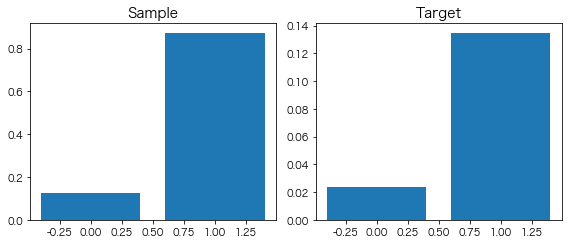

----------------------------------------------------------------------------------------------------
ar_nm_mtch_f_N
[0.        0.0542191 1.01     ]


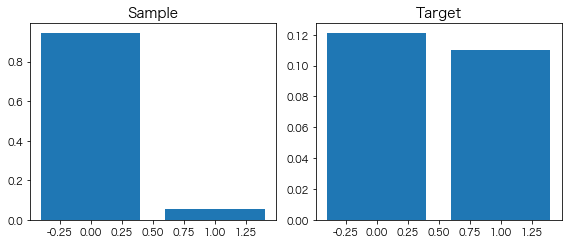

----------------------------------------------------------------------------------------------------
ar_nm_mtch_f_Y
[0.   1.   1.01]


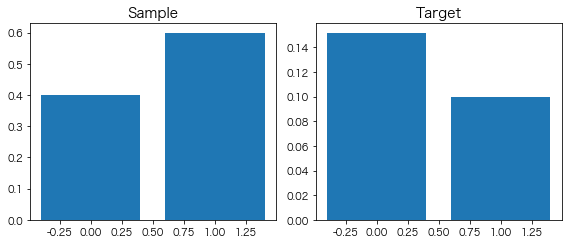

----------------------------------------------------------------------------------------------------
ar_nm_mtch_f_null
[0.         0.34625145 1.01      ]


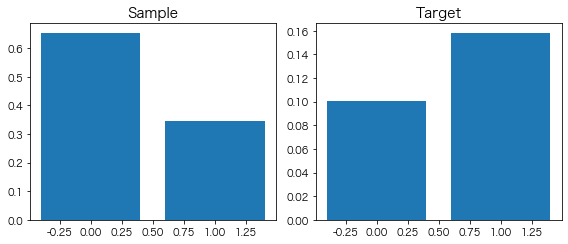

----------------------------------------------------------------------------------------------------
ar_mtch_f_N
[0.         0.39978323 1.01      ]


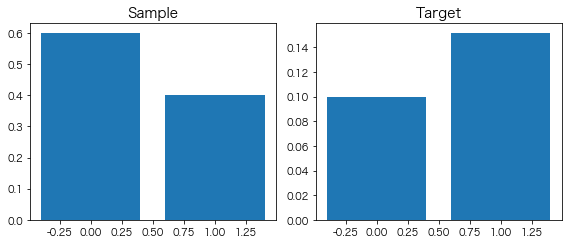

----------------------------------------------------------------------------------------------------
ar_mtch_f_Y
[0.   1.   1.01]


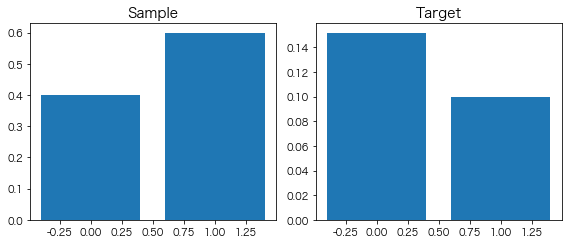

----------------------------------------------------------------------------------------------------
ar_mtch_f_null
[0.00000000e+00 6.87321561e-04 1.01000000e+00]


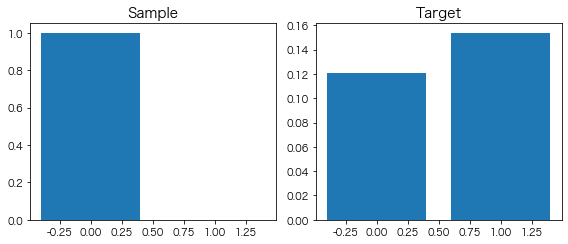

----------------------------------------------------------------------------------------------------
est_incm_f_N
[0.         0.00256424 1.01      ]


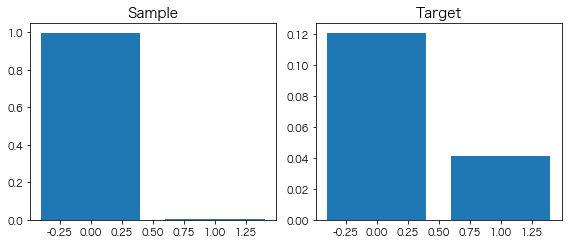

----------------------------------------------------------------------------------------------------
est_incm_f_Y
[0.   1.   1.01]


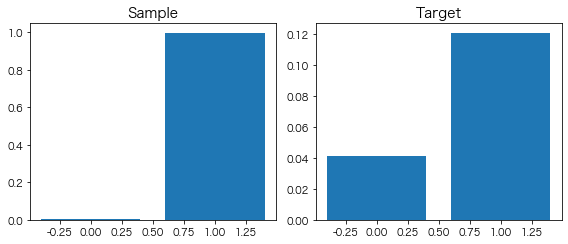

----------------------------------------------------------------------------------------------------
not_slry_ocp_f_N
[0.         0.04126573 1.01      ]


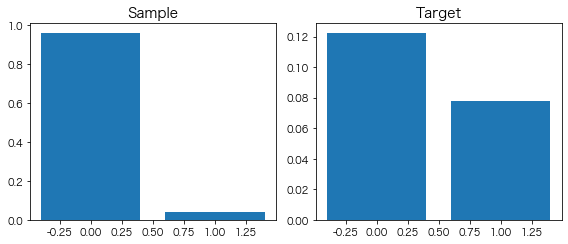

----------------------------------------------------------------------------------------------------
not_slry_ocp_f_Y
[0.       0.029687 1.01    ]


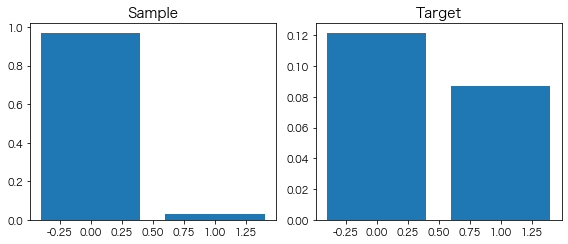

----------------------------------------------------------------------------------------------------
not_slry_ocp_f_null
[0.   1.   1.01]


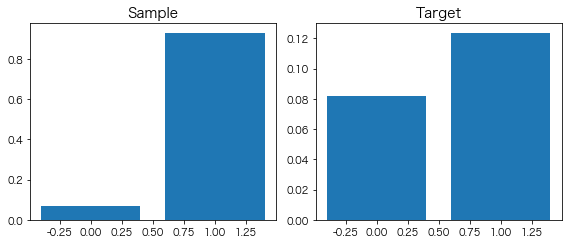

----------------------------------------------------------------------------------------------------
sngl_ip_id_f_N
[0.         0.00105742 1.01      ]


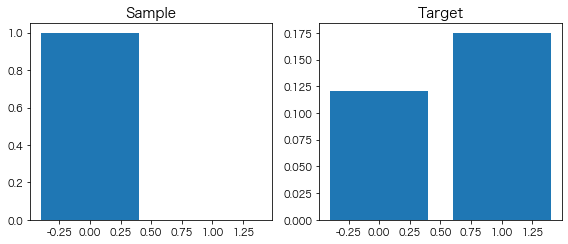

----------------------------------------------------------------------------------------------------
sngl_ip_id_f_Y
[0.   1.   1.01]


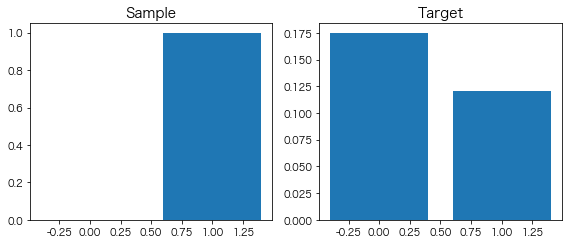

----------------------------------------------------------------------------------------------------
mx_incm_f_N
[0.00000000e+00 2.64354446e-05 1.01000000e+00]


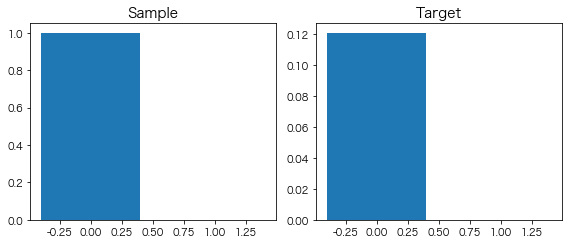

----------------------------------------------------------------------------------------------------
mx_incm_f_Y
[0.         0.12710162 1.01      ]


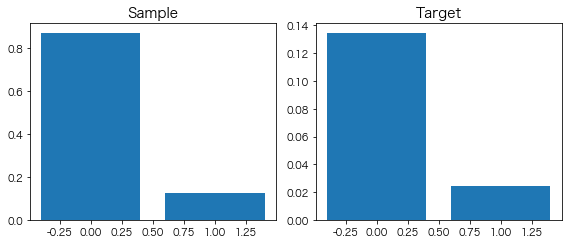

----------------------------------------------------------------------------------------------------
mx_incm_f_null
[0.   1.   1.01]


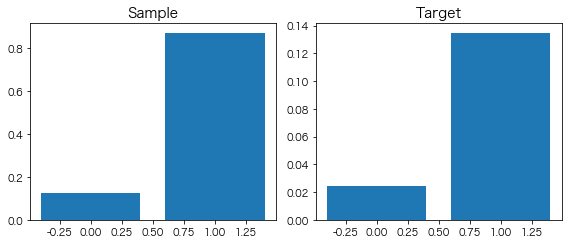

----------------------------------------------------------------------------------------------------
mx_mrch_age_f_N
[0.00000000e+00 2.64354446e-04 1.01000000e+00]


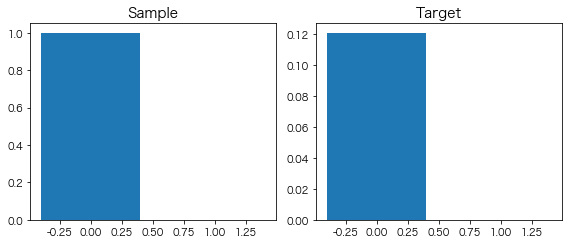

----------------------------------------------------------------------------------------------------
mx_mrch_age_f_Y
[0.        0.1268637 1.01     ]


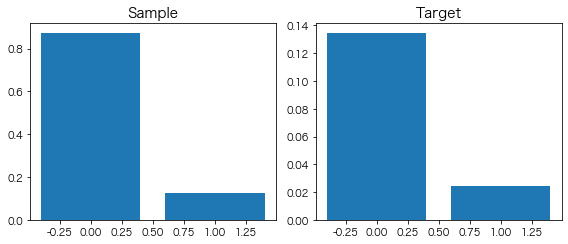

----------------------------------------------------------------------------------------------------
mx_mrch_age_f_null
[0.   1.   1.01]


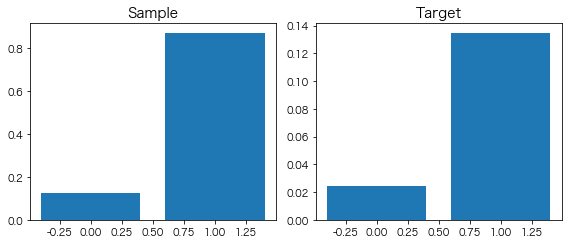

----------------------------------------------------------------------------------------------------
mn_sellr_id_f_N
[0.00000000e+00 2.64354446e-04 1.01000000e+00]


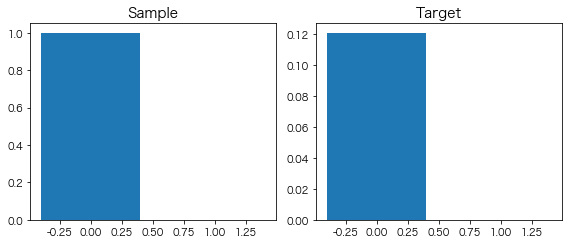

----------------------------------------------------------------------------------------------------
mn_sellr_id_f_Y
[0.        0.1268637 1.01     ]


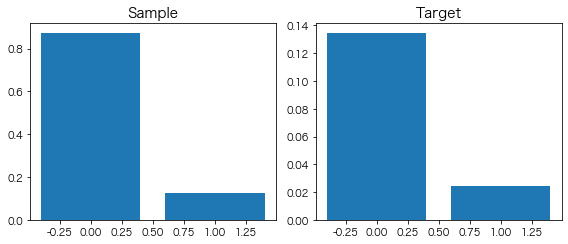

----------------------------------------------------------------------------------------------------
mn_sellr_id_f_null
[0.   1.   1.01]


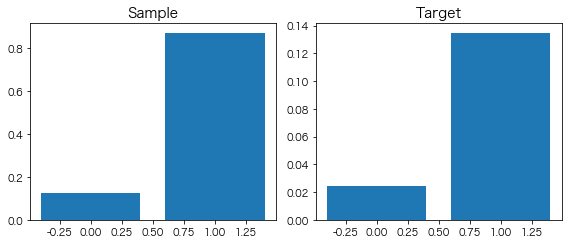

----------------------------------------------------------------------------------------------------
sellr_id_f_N
[0.        0.0012689 1.01     ]


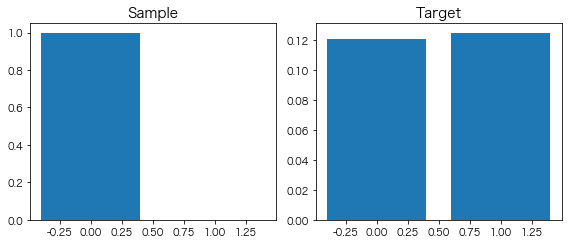

----------------------------------------------------------------------------------------------------
sellr_id_f_Y
[0.   1.   1.01]


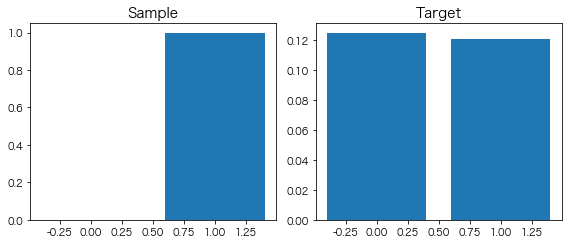

----------------------------------------------------------------------------------------------------
fnl_f_N
[0.         0.00465264 1.01      ]


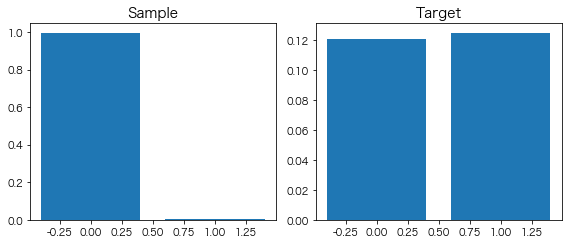

----------------------------------------------------------------------------------------------------
fnl_f_Y
[0.   1.   1.01]


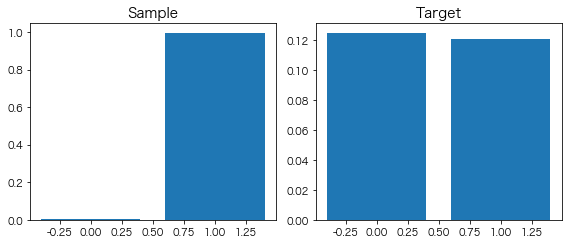

----------------------------------------------------------------------------------------------------


In [215]:
for var in dok.keys():
    print(var)
    print(dok[var].bin_edges)
    N = np.histogram(X[var], bins=dok[var].bin_edges)[0]
    N1 = np.histogram(X[var][y==1], bins=dok[var].bin_edges)[0]
    N1 = N1/N
    N = N/sum(N)
    axes = plt.subplots(1,2,figsize=(8,3.5))[1]
    axes[0].bar(np.arange(len(N)), N)
    axes[0].set_title("Sample", fontsize=14)
    axes[1].bar(np.arange(len(N)), N1)
    axes[1].set_title("Target", fontsize=14)
    plt.tight_layout()
    plt.show()
    print("-"*100)